$\setcounter{secnumdepth}{0}$
$\date{}$

## Completed by:   
*   Denys Botuk

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ruptures as rpt
import statsmodels as sm
from matplotlib import pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import splrep, splev
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.api import OLS, add_constant
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from scipy.stats import wilcoxon
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We consider the following data sets:

* **Data 1:** retail sales of beer, wine and liquor in the U.S. Monthly data from January 1992 till November 2017 (Source: Federal Reserve Bank of St. Louis, file: _BeerWineUS.csv_).

* **Data 2:** real (inflation corrected) interest rate for bank deposits with investment durations of longer than two years (Source: Deutsche Bundesbank / German Central Bank, file: _interestrates2years.csv_).

* **Data 3:** crude oil price per barrel; (Source: Federal Reserve Bank of St. Louis, file: _CrudeOil.csv_)

Let's visualize the them to understand, what data we are going to working with, their properties and types.

The first dataset contains the information about **retail sales of alcohol** (including beer, wine, liquor, etc) in U.S. 

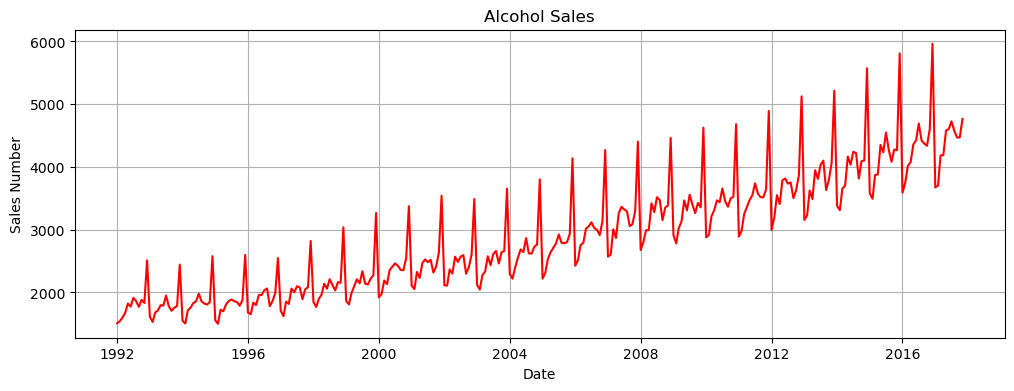

In [2]:
beer_wine_df = pd.read_csv('BeerWineUS.csv')
beer_wine_df['DATE'] = pd.to_datetime(beer_wine_df['DATE'])
beer_wine_df.set_index('DATE', inplace=True)

plt.figure(figsize=(12,4))
plt.plot(beer_wine_df.index, beer_wine_df['MRTSSM4453USN'], color='red')
plt.title('Alcohol Sales')
plt.xlabel('Date')
plt.ylabel('Sales Number')
plt.grid()
plt.show()

So, we have **monthly** data starting from Jan 1992 till Nov 2017. 

Here we can clearly notice that this time series contains the year **seasonality** with some increasing **trend**.

The next dataset contains the data about **interest rate** for bank deposits with investment durations of longer than two years starting.

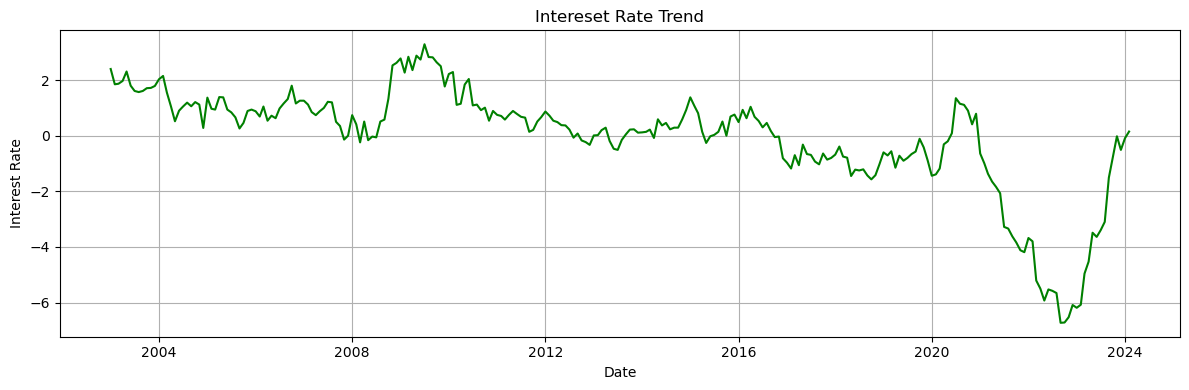

In [3]:
interest_rates_df = pd.read_csv('interestrates2years.csv', names=['DATE', 'INTEREST_RATE'], header=None, sep=';', index_col=False)
interest_rates_df['INTEREST_RATE'] = interest_rates_df['INTEREST_RATE'].str.replace(',', '.', regex=True).astype(float)
interest_rates_df['DATE'] = pd.to_datetime(interest_rates_df['DATE'])
interest_rates_df.set_index('DATE', inplace=True)

plt.figure(figsize=(12,4))
plt.plot(interest_rates_df.index, interest_rates_df['INTEREST_RATE'], color='green')
plt.title('Intereset Rate Trend')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.grid()
plt.tight_layout()
plt.show()

So, here we have **monthly** data starting from Jan 2003 till Feb 2024

The time series looks like a **random walk** with **no trend** and **no seasonality**.

Then let's look at the last 3rd dataset, which contains the time series information about **crude oil price per barrel**.

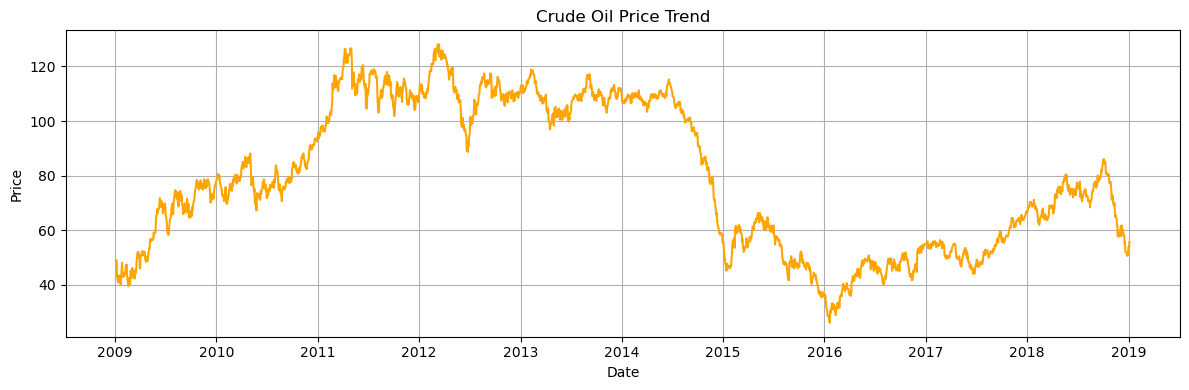

In [4]:
crude_oil_df = pd.read_csv('CrudeOil.csv')
crude_oil_df['DATE'] = pd.to_datetime(crude_oil_df['DATE'])
crude_oil_df.set_index('DATE', inplace=True)
crude_oil_df = crude_oil_df.dropna()

plt.figure(figsize=(12,4))
plt.plot(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'], color='orange')
plt.title('Crude Oil Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.tight_layout()
plt.show()

This dataset contains **daily** data starting from Jan 6, 2009 till Jan 4, 2019 taking into account only working days.

Here we can observe some long-term upward and downward **trends** with significant **noise**, which is present probably due to daily market volatility. We can't recognize a clear **seasonality** pattern.

# Task #1
## Trend extraction for non-seasonal time series of the crude oil price
### (a) Try several moving average techniques to extract the trend ($ma$ in R). Which orders/form of moving averages do provide the best results? Use just figures of the trend and the difference $Y_t − T_t$.

So, as I mentioned before, crude oil price dataset contains some long-term upward and downward trends, which I am going to extract.

Then I am going to try different techniques for trend extraction:

* simple moving average (SMA)

* double moving average (DMA)

* weighted moving average (WMA)

Each of technique I will try with different $k$ orders $\{5, 67, 269\}$ (weekly, seasonaly (3 months), yearly averages).

In [5]:
k_values = [5, 67, 269]
methods_ma = ['MA', 'DMA', 'WMA']
methods = []

So, the first approach is Simple Moving Average ($k$-MA):
$$T_t = \frac{1}{k}\sum\limits_{j=-m}^{m}Y_{t+j} \qquad \text{where} \qquad m = \frac{k-1}{2}$$

In [6]:
for k_value in k_values:
    crude_oil_df[str(k_value) + '-MA'] = crude_oil_df['DCOILBRENTEU'].rolling(window=k_value, center=True).mean()
    methods.append(str(k_value) + '-MA')

The second I will try is Double Moving Average ($k \times k$-MA):
$$T_t = \frac{1}{k}\sum\limits_{j=-m}^{m}Y_{t+j} \qquad \text{where} \qquad m = \frac{k-1}{2}$$
$$T^{'}_t = \frac{1}{k}\sum\limits_{j=-m}^{m}T_{t+j}$$

In [7]:
for k_value in k_values:
    crude_oil_df[str(k_value) + '-DMA'] = crude_oil_df[str(k_value) + '-MA'].rolling(window=k_value, center=True).mean()
    methods.append(str(k_value) + '-DMA')

And the 3rd approach is weighted moving average ($k$-WMA):
$$T_t = \sum\limits_{j=-m}^{m}a_jY_{t+j} \qquad \text{with} \qquad a_{-j} = a_j$$
Here I will use quadratic weights:
$$a_j = \frac{Q(j,m)}{\sum\limits_{i=-m}^{m}Q(i,m)}, \qquad \text{where} \qquad Q(j, m) = \begin{cases} (1 - (\frac{i}{2})^2)^2 & \text{for} -m \leq i \leq m \\ 0 & \text{else} \end{cases}$$

In [8]:
def quadratic_weighted_moving_average(data, window):
    m = window // 2
    weights = np.array([(1 - (i/m)**2) ** 2 for i in range(-m, m+1)])
    return data.rolling(window=window, center=True).apply(lambda x: sum(weights * x) / sum(weights), raw=True)

for k_value in k_values:
    crude_oil_df[str(k_value) + '-WMA'] = quadratic_weighted_moving_average(crude_oil_df['DCOILBRENTEU'], k_value)
    methods.append(str(k_value) + '-WMA')

And now let's visualize the results and compare it with original data. To better understand the main properties let's add the difference $Y_t - T_t$ to our plots.

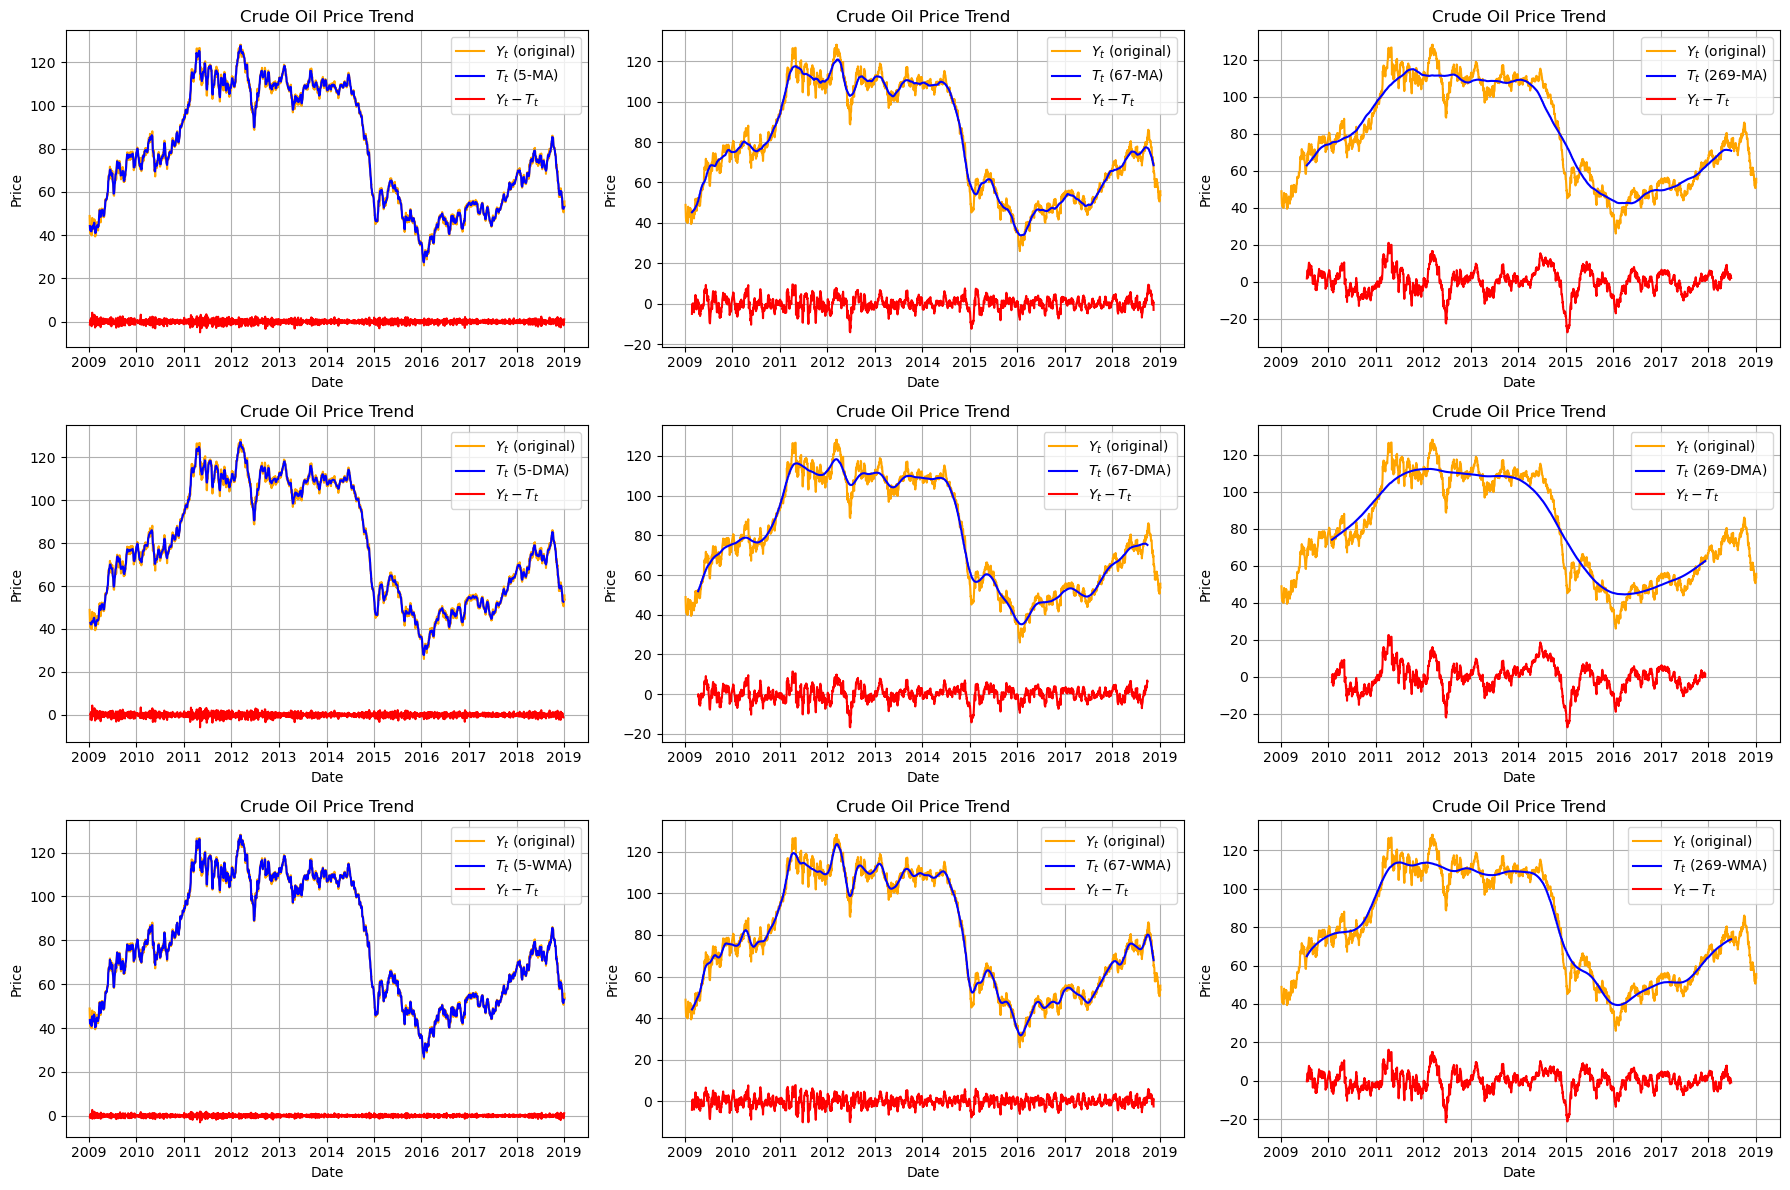

In [9]:
plt.figure(figsize=(18, 12))

i = 1
for method in methods_ma:
    for k_value in k_values:
        plt.subplot(len(methods_ma), len(k_values), i)
        plt.plot(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'], color='orange', label=r'$Y_t$ (original)')
        plt.plot(crude_oil_df.index, crude_oil_df[str(k_value) + '-' + method], color='blue', label=r'$T_t$ (' + str(k_value) + '-' + method + ')')
        plt.plot(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'] - crude_oil_df[str(k_value) + '-' + method], label=r'$Y_t - T_t$', color='red')
        plt.title('Crude Oil Price Trend')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        i+=1

plt.tight_layout()
plt.show()

So, given these plots we can conclude the following:

* weekly averaging ($k = 5$) mostly reproduces the noise of time series, the most precise is $5$-WMA, which covers most the spikes and provides the least error;

* seasonal (3 months) averaging ($k = 67$) coped with the noise and holds the biggest spikes, the most smoother is $67$-DMA and $67$-WMA covers the spikes the most;

* year averaging ($k=269$) mostly provide the global trend, the smoothest is $269$-DMA, $269$-WMA covers the extreme increases/decreases the best

So, depending on the purpose we can choose different approaches. If we would like to denoise time series, all the approaches of $67$ order are good enough, if we are interesting to cover the biggest spikes, than it's better to choose WMA. If we just are going to extract the very global trend, we can choose $269$-DMA, if we are interested in more precise changes, then $269$-WMA will be the best choice.

### (b) Does it make sense to apply centered moving average ($2 \times k$ MA) smoothing? Explain and motivate your answer.

The time series data, we are observing exhibits an irregular trend, which most likely doesn't have any seasonality.
Centered moving average smoothing approach allows us to capture the seasonality, but as we are not observing any, then there is no specific reason to use it.

### (c) Since the time series exhibits a very irregular trend apply and visualize the local polynomial regression. In your particular implementation verify the functional form of the weights used for trend extraction.

Let's try one more technique - local polynomial regression.

It is calculated by the following formula:

$$\sum\limits_{t=1}^{\tau} w_t(t_0)(Y_t - b_0 - b_1\cdot(t-t_0) - \frac{1}{2}b_2(t-t_0)^2)^2 \rightarrow \min \qquad \text{w.r.t} \qquad b_0, b_1, b_2$$

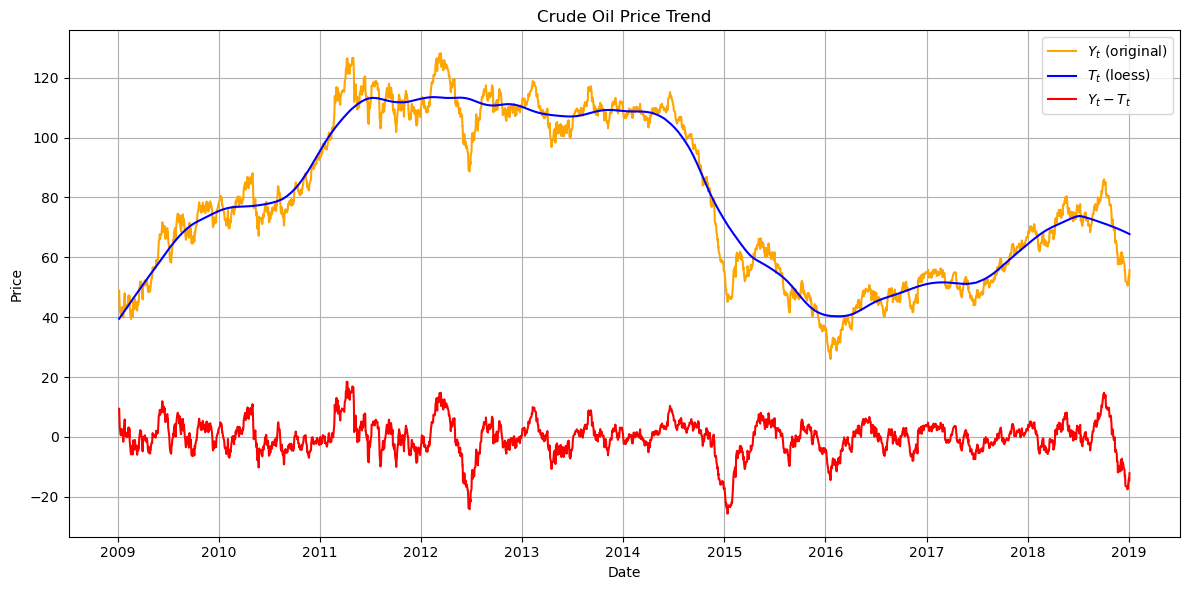

In [10]:
crude_oil_df['LOESS'] = lowess(crude_oil_df['DCOILBRENTEU'], crude_oil_df.index, frac=0.1, delta=1, return_sorted=False)
methods.append('LOESS')

plt.figure(figsize=(12, 6))
plt.plot(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'], color='orange', label=r'$Y_t$ (original)')
plt.plot(crude_oil_df.index, crude_oil_df['LOESS'], color='blue', label=r'$T_t$ (loess)')
plt.plot(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'] - crude_oil_df['LOESS'], label=r'$Y_t - T_t$', color='red')
plt.title('Crude Oil Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In such implementation we use two parameters 'frac' and 'delta', which specify the form of the weights in the following way:
$$w_t(t_0) = W(\frac{t_i - t_0}{h}) \qquad W(u) = \begin{cases} (1 - |u|^3)^3, & |u| \leq \delta \\ 0, & |u| > \delta \end{cases}$$
where 

* $h = n \cdot$'frac', $n$ - size of the dataset

* $\delta$ = 'delta'

So, we can see here that such approach is also good enough, the most problematic regions are period between 2012 and 2013 and between 2014 and 2015.

### (d) Apply the B-spline approach to extract the trend. Explain precisely how many splines you use, the underlying time grid and the order of polynomials.

One more approach for extraction the trend is B-spline technique:
$$Y_t = b_0 + \sum\limits_{i=1}^{k} b_i B_i^{(q)}(t) + \epsilon_t$$
where:
* B-splines $B_i^{(q)}$ are $k$ polynomials of order $q$.

* B-spline of order $q$ in the subinterval $i$ is recursively defined as

$$B_i^{(q)}(t) = \alpha_{i,q}(t)B_i^{(q-1)}(t) + (1 - \alpha_{i+1,q}(t))B_{i+1}^{(q-1)}(t)$$
$$\alpha_{i,q}(t) = \frac{t - t_i}{t_{i+q-1} - t_t} \qquad B_i^{(0)}(t) = \mathbf{1}_{[t_i, t_{i+1})}(t)$$

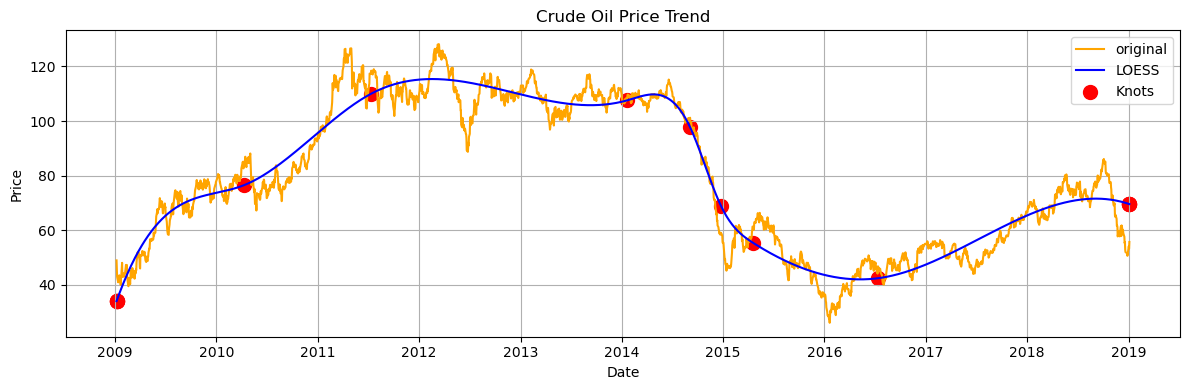

In [11]:
smoothing_factor = 100_000
k = 3

tck = splrep(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'], s=smoothing_factor, k=k)
t, c, k = tck
crude_oil_df['B-SPLINE'] = splev(crude_oil_df.index, tck)
methods.append('B-SPLINE')

plt.figure(figsize=(12, 4))
plt.plot(crude_oil_df.index, crude_oil_df['DCOILBRENTEU'], color='orange', label='original')
plt.plot(crude_oil_df.index, crude_oil_df['B-SPLINE'], color='blue', label='LOESS')
plt.scatter(pd.to_datetime(t), splev(t, tck), color='red', marker='o', s=100, label='Knots')
plt.title('Crude Oil Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

So, we can see the red knots, which make the underlying time grid, which correspond to:

In [12]:
pd.to_datetime(t).unique().values

array(['2009-01-06T00:00:00.000000000', '2010-04-09T00:00:00.000000000',
       '2011-07-13T00:00:00.000000000', '2014-01-20T00:00:00.000000000',
       '2014-09-03T00:00:00.000000000', '2014-12-24T00:00:00.000000000',
       '2015-04-20T00:00:00.000000000', '2016-07-13T00:00:00.000000000',
       '2019-01-04T00:00:00.000000000'], dtype='datetime64[ns]')

The order of polynomials that we've used is equal to $k$:

In [13]:
k

3

Due to properties of B-splines and specific boundary conditions we should use $k+1$ on both boundaries, where $k$ is an order of polynomials. 

From our implementation we get that in total we use $t$ knots, which is equal to:

In [14]:
len(t)

15

Given that, the number of splines is $t - 2\cdot(k+1) + 1$:

In [15]:
len(t) - 2 * (k+1) + 1

8

### (e) For every of the above approaches extract the irregular component (there is no seasonal component) and plot its autocorrelation. If there are significant lags is this good or bad for further analysis?

Every time series $Y_t$ could be decomposed into the sum of three components:
$$Y_t = T_t + S_t + I_t$$
where, $T_t$ - the trend component, $S_t$ - the seasonal component, $I_t$ - the irregular component.

From the shape of our time series, we can see that there is no seasonal component, then given trend component $T_t$ we can extract irregular component by the following approach:
$$I_t = Y_t - T_t$$

In [16]:
irregular_df = pd.DataFrame()
for method in methods:
    irregular_df[method] = crude_oil_df['DCOILBRENTEU'] - crude_oil_df[method]

Then let's look at ACFs up to 50 lags of irregular components for each approach.

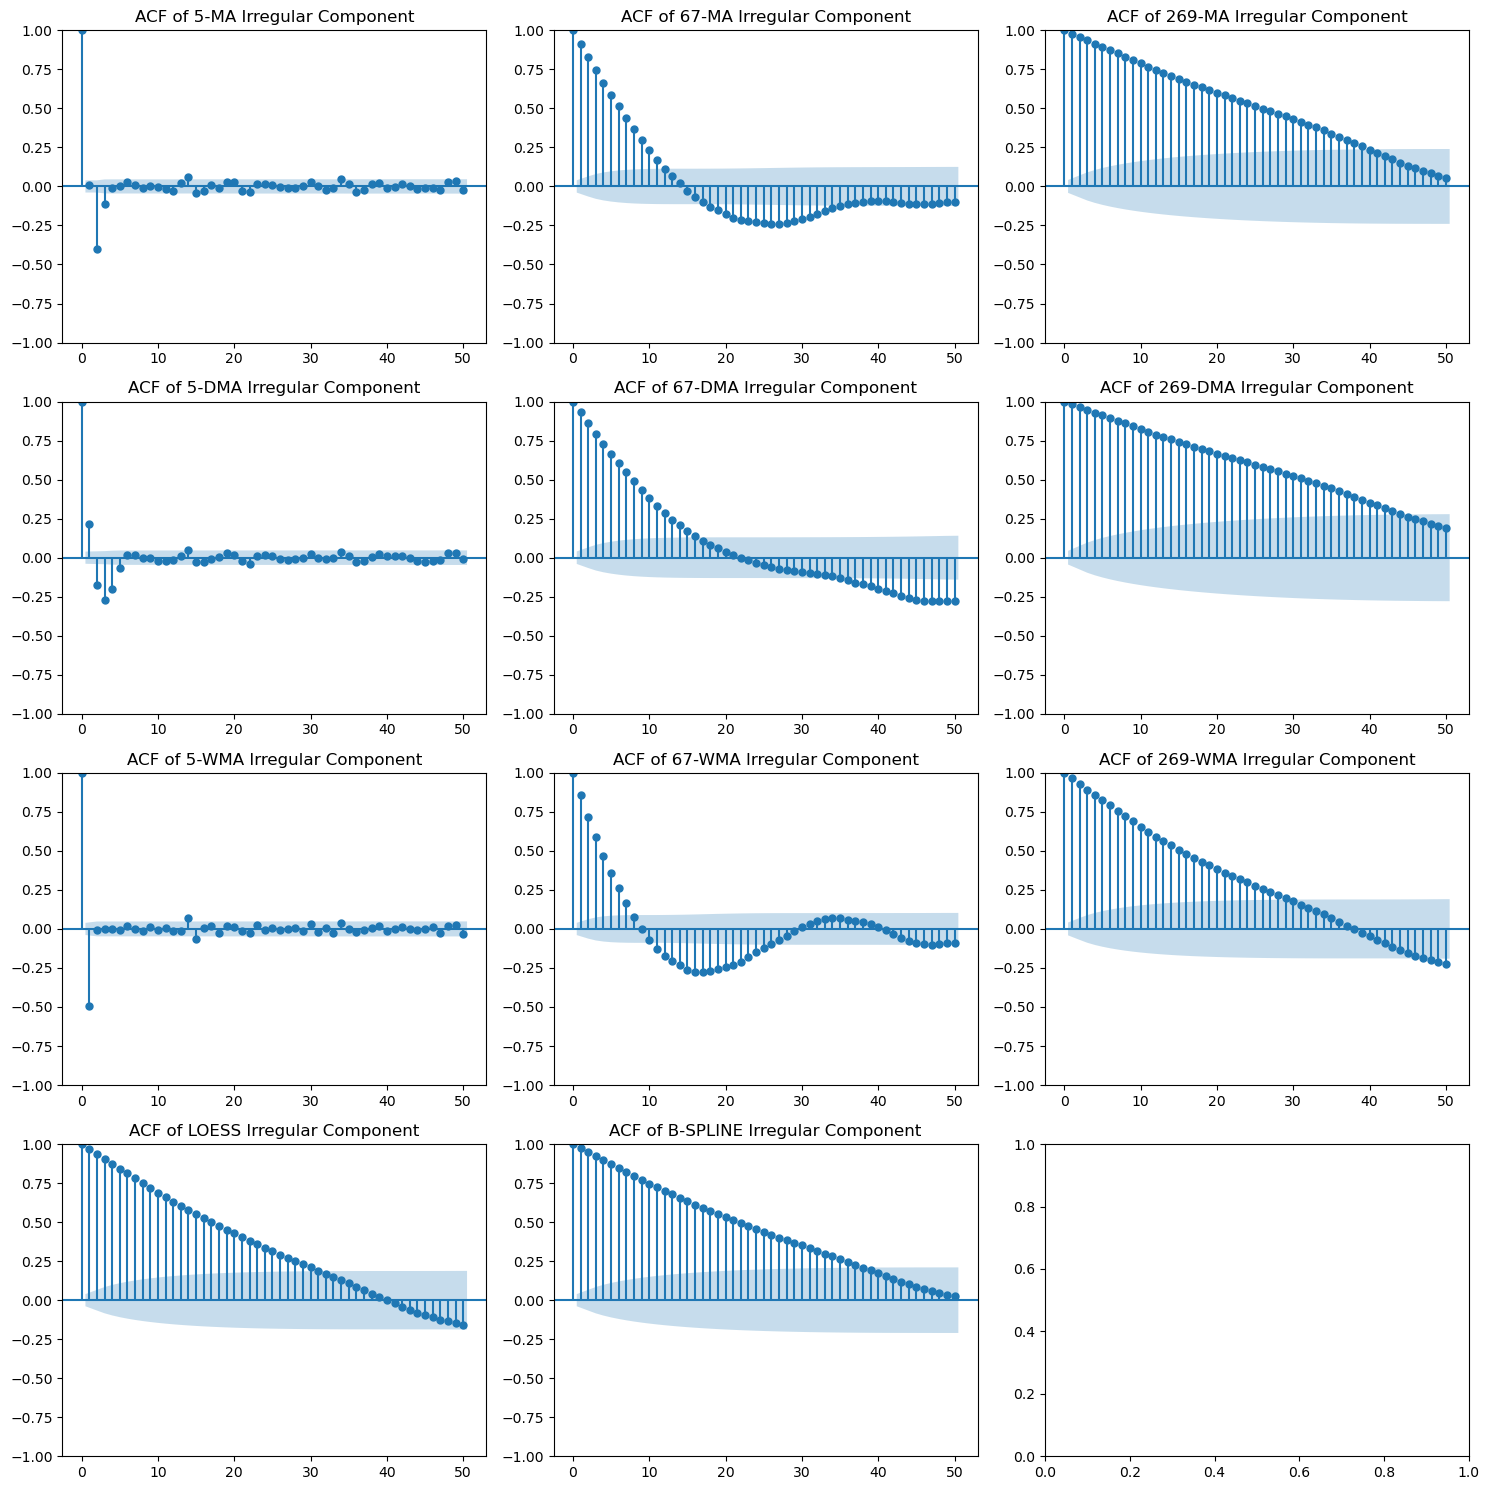

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
i = 1
for i, method in enumerate(methods):
    plot_acf(irregular_df[method].dropna(), lags=50, ax=axes[i // 3, i % 3], title=f'ACF of {method} Irregular Component')

plt.tight_layout()
plt.show()

As expected approaches of $5$ order have a small "memory", which indicates the presence of short-term dependencies in the data. It is usual, because each value is calculated based on 5 entries. ACF lags near zero suggest randomness. It ensures that residuals are white noise, which is also obvious as we observed noise from the plots. The presence of a few significant lags can enhance the predictive power of simple models by incorporating these dependencies. This is particularly useful in forecasting applications.

For $67$ order we observe unstability of ACF. An unstable ACF indicates that the time series is non-stationary. Non-stationarity violates the assumptions of many time series models, making it challenging to model the data directly without transformation.

For $269$ order, LOESS and B-spline approaches demonstrate a good "memory", which indicates stationarity. Constant decreasing suggests an exponential decay pattern, where each value in the series is influenced by its previous values, but this influence diminishes over time. All these properties can simplify modeling and forecasting.

# Task #2
## Simple forecasting and forecasting with exponential smoothing of the crude oil price. Split the time series into three phases using the observations $[500;700]$; $[1200;1400]$ and $[1500;2300]$. For each phase do the following (use the first $100$ observations to calibrate the model if needed).
### (a) Compute simple one-step-ahead forecasts for the test data set using naїve, absolute trend and relative trend methods.

I'm going to do a simple forecasting using some quite simple techniques:

* naive forecast

* naive forecast with absolute trend

* naive forecast with relative trend

The main idea of **Naive Forecast** is to predict the one-step-ahead value by the current one:
$$\hat{Y}_{t+1} = Y_t$$

**Absolute trend** approach takes also into account the absolute change between previous values ("same-change" principle):
$$\hat{Y}_{t+1} = Y_t + (Y_t - Y_{t-1})$$

**Relative trend** method follows the same principle, but takes into account the relative change between previous values:
$$\hat{Y}_{t+1} = Y_t \cdot\frac{Y_t}{Y_{t-1}}$$

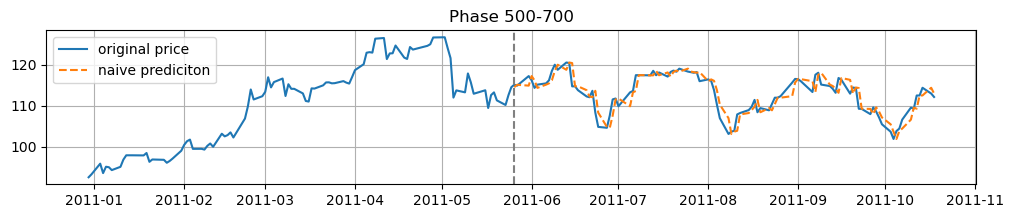

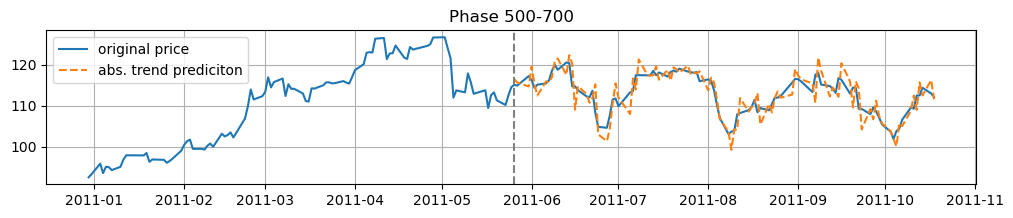

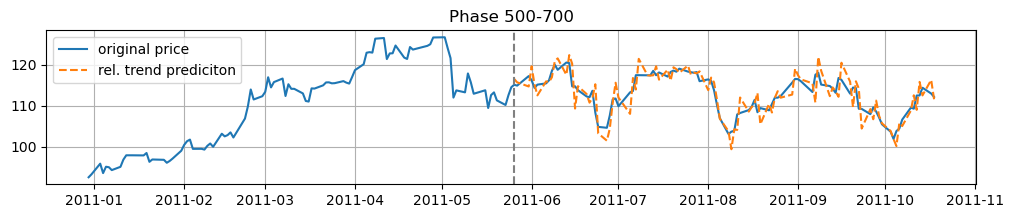

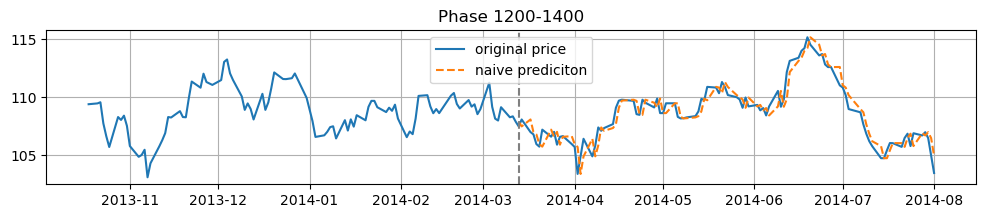

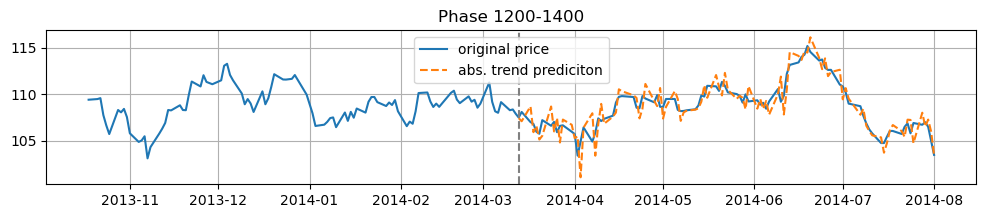

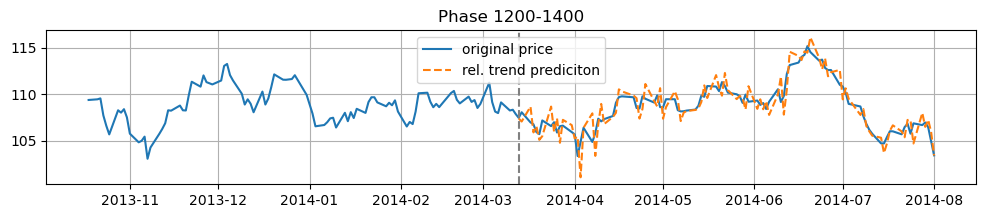

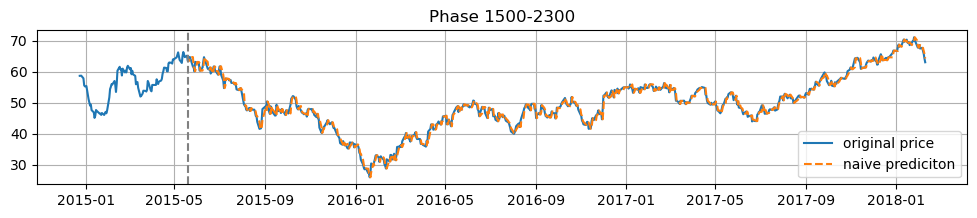

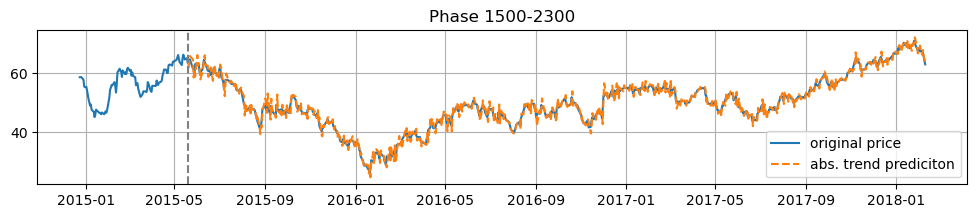

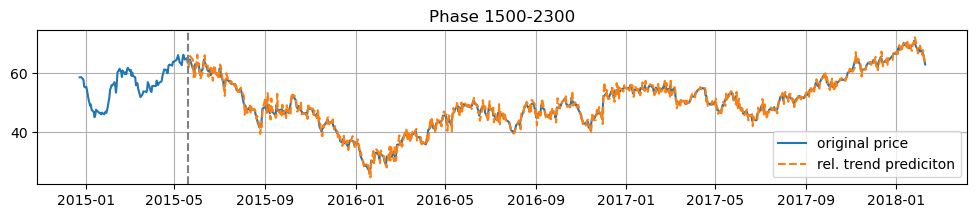

In [18]:
def naive_forecast(train_data):
    return train_data[-1]

def absolute_trend_forecast(train_data):
    return train_data[-1] + (train_data[-1] - train_data[-2])

def relative_trend_forecast(train_data):
    return train_data[-1] * (train_data[-1] / train_data[-2])

phases = [(500, 700), (1200, 1400), (1500, 2300)]

for start, end in phases:
    phase_data = crude_oil_df['DCOILBRENTEU'][start:end].values
    train_data = phase_data[:100]
    test_data = phase_data[100:]
    
    train_dates = crude_oil_df.index[start:end].values
    test_dates = crude_oil_df.index[start:end].values[100:]
    
    naive_forecasts = []
    abs_trend_forecasts = []
    rel_trend_forecasts = []
    
    for i in range(len(test_data)):
        naive_forecasts.append(naive_forecast(train_data))
        abs_trend_forecasts.append(absolute_trend_forecast(train_data))
        rel_trend_forecasts.append(relative_trend_forecast(train_data))
        train_data = np.append(train_data, test_data[i])
    
    plt.figure(figsize=(12, 2))
    plt.plot(train_dates, phase_data, label='original price')
    plt.plot(test_dates, naive_forecasts, label='naive prediciton', linestyle='--')
    plt.axvline(x=train_dates[100], color='gray', linestyle='--')
    plt.title(f'Phase {start}-{end}')
    plt.legend()
    plt.grid()

    plt.figure(figsize=(12, 2))
    plt.plot(train_dates, phase_data, label='original price')
    plt.plot(test_dates, abs_trend_forecasts, label='abs. trend prediciton', linestyle='--')
    plt.axvline(x=train_dates[100], color='gray', linestyle='--')
    plt.title(f'Phase {start}-{end}')
    plt.legend()
    plt.grid()

    plt.figure(figsize=(12, 2))
    plt.plot(train_dates, phase_data, label='original price')
    plt.plot(test_dates, rel_trend_forecasts, label='rel. trend prediciton', linestyle='--')
    plt.axvline(x=train_dates[100], color='gray', linestyle='--')
    plt.title(f'Phase {start}-{end}')
    plt.legend()
    plt.grid()
    
    plt.show()

From the plots above we observe naive forecast is a good one as expected for noisy time series with obvious trends. Absolute and relative trends are also so good for the periods, when time series is strongly increasing or decreasing, at the moments, when it changes the sign, these techniques make a forecast spiky.

### (b) Compute simple one-step-ahead forecasts using EWMA and Holt (with optimal smoothing parameters).

Let's try two more advanced techniques:

* exponentially weighted moving average forecast

$$\hat{Y}_{t+1} = \sum\limits_j\alpha(1 - \alpha)^jY_{t - j} \qquad \alpha \text{- memory parameter}$$

* Holt forecast

$$\hat{Y}_{t+h} = L_t + T_th$$
$$L_t = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1}) \qquad \text{global trend}$$
$$T_t = \beta(L_t - L_{t-1}) + (1 - \beta)T_{t-1} \qquad \text{local trend}$$

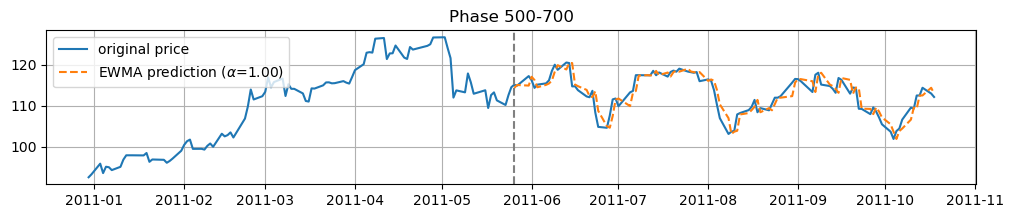

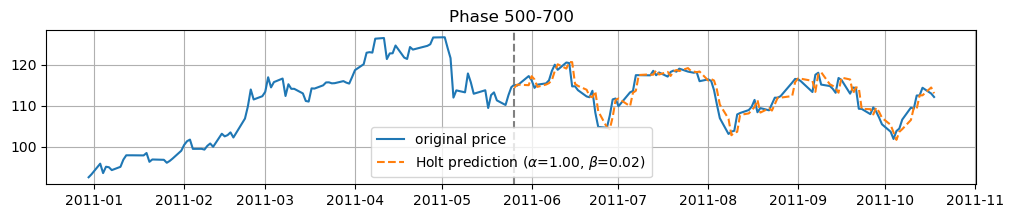

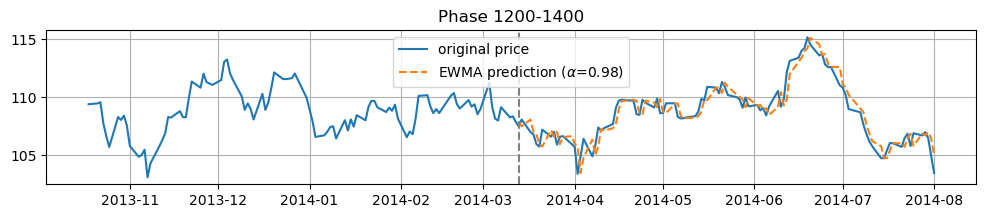

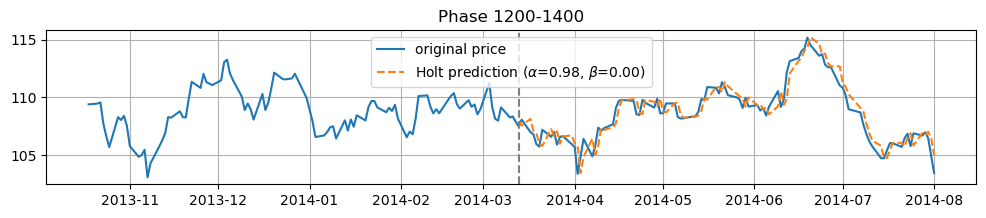

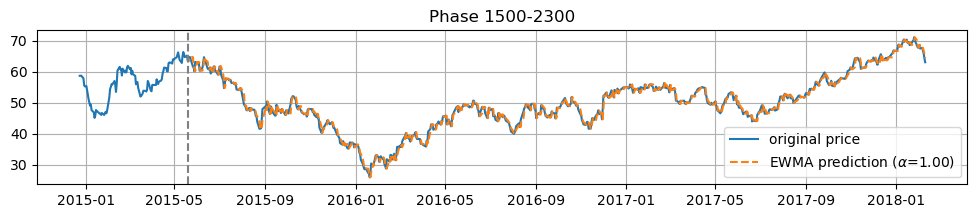

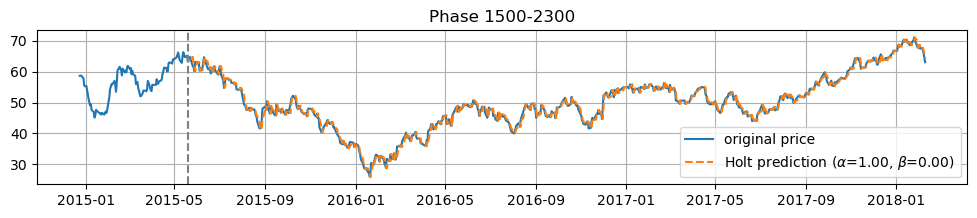

In [19]:
for start, end in phases:
    phase_data = crude_oil_df['DCOILBRENTEU'][start:end].values
    train_data = phase_data[:100]
    test_data = phase_data[100:]
    
    train_dates = crude_oil_df.index[start:end].values
    test_dates = crude_oil_df.index[start:end].values[100:]
    
    ewma_forecasts = []
    holt_forecasts = []
    
    for i in range(len(test_data)):
        ewma_model = SimpleExpSmoothing(train_data, initialization_method='estimated').fit(optimized=True)
        ewma_forecasts.append(ewma_model.forecast(1)[0])
        
        holt_model = Holt(train_data).fit(optimized=True)
        holt_forecasts.append(holt_model.forecast(1)[0])
        
        train_data = np.append(train_data, test_data[i])
    
    plt.figure(figsize=(12, 2))
    plt.plot(train_dates, phase_data, label='original price')
    plt.plot(test_dates, ewma_forecasts, label=r'EWMA prediction ($\alpha$=' + str('{:.2f}'.format(ewma_model.model.params['smoothing_level'])) + ')', linestyle='--')
    plt.axvline(x=train_dates[100], color='gray', linestyle='--')
    plt.title(f'Phase {start}-{end}')
    plt.legend()
    plt.grid()
    
    plt.figure(figsize=(12, 2))
    plt.plot(train_dates, phase_data, label='original price')
    plt.plot(test_dates, holt_forecasts, label=r'Holt prediction ($\alpha$=' + str('{:.2f}'.format(holt_model.params['smoothing_level'])) + r', $\beta$=' + str('{:.2f}'.format(holt_model.params['smoothing_trend'])) + ')', linestyle='--')
    plt.axvline(x=train_dates[100], color='gray', linestyle='--')
    plt.title(f'Phase {start}-{end}')
    plt.legend()
    plt.grid()

As we previously noticed naive forecast is good enough, what we also observed from EWMA and Holt forecasting techniques. In all phases optimal $\alpha$ value is about or equal $1$ as well as $\beta$ is about or equal to $0$. As we observe there are no significant changes in level on these phases. Data are quite noisy with increasing and decreasing parts.

### (c) Compute the MSE, MAE, U and Minzer-Zarnowitz $R^2$ (regression of predictions on the true values) for the last $100$ observations of each phase.

To be more precise and prove our assumptions by some metrics, let's calculate the following metrics for the last 100 observations of each phase:

* mean squared error (MSE):
$$MSE_h = \frac{1}{\tau - h}\sum\limits_{t=1}^{\tau - h}\hat{\epsilon}^2_{t+h}$$

* mean absolute error (MAE):
$$MAE_h = \frac{1}{\tau - h}\sum\limits_{t=1}^{\tau - h}|\hat{\epsilon}_{t+h}|$$

* Theil's U:
$$U_h = \sqrt{\frac{\sum\limits_{t=1}^{\tau-h}(\frac{\hat{Y}_{t+h} - Y_{t+h}}{Y_t})^2}{\sum\limits_{t=1}^{\tau-h}(\frac{Y_t - Y_{t+h}}{Y_t})^2}}$$

* Minzer-Zarnowitz $R^2$:
$$R^2 \text{ of LR of } \hat{Y}_{t+h} \text{ on } Y_{t+h}$$

In [20]:
def theils_u(true_values, predicted_values):
    true_values_shifted = np.array(true_values)[1:]
    true_values = np.array(true_values)[:-1]
    predicted_values_shifted = np.array(predicted_values)[1:]
    return np.sqrt(np.sum(((predicted_values_shifted - true_values_shifted) / true_values)**2) / np.sum(((true_values - true_values_shifted) / true_values)**2))

def minzer_zarnowitz_R(true_values, predicted_values):
    X = add_constant(predicted_values)
    reg_model = OLS(true_values, X).fit()
    r_squared = reg_model.rsquared
    return r_squared

metrics_per_phase = dict()
for start, end in phases:
    phase_data = crude_oil_df['DCOILBRENTEU'][start:end].values
    train_data = phase_data[:100]
    test_data = phase_data[100:]
    
    train_dates = crude_oil_df.index[start:end].values
    test_dates = crude_oil_df.index[start:end].values[100:]
    
    naive_forecasts = []
    abs_trend_forecasts = []
    rel_trend_forecasts = []
    ewma_forecasts = []
    holt_forecasts = []
    
    for i in range(len(test_data)):
        naive_forecasts.append(naive_forecast(train_data))
        
        abs_trend_forecasts.append(absolute_trend_forecast(train_data))
        
        rel_trend_forecasts.append(relative_trend_forecast(train_data))
        
        model = SimpleExpSmoothing(train_data, initialization_method='estimated').fit(optimized=True)
        ewma_forecast = model.forecast(1)[0]
        ewma_forecasts.append(ewma_forecast)
        
        holt_model = Holt(train_data).fit(optimized=True)
        holt_forecast = holt_model.forecast(1)[0]
        holt_forecasts.append(holt_forecast)
        
        train_data = np.append(train_data, test_data[i])
    
    print(f'\nPHASE: [{start}:{end}]')
    
    mse = dict()
    mae = dict()
    u = dict()
    mzr = dict()
    
    mse['naive'] = mean_squared_error(test_data[-100:], naive_forecasts[-100:])
    mae['naive'] = mean_absolute_error(test_data[-100:], naive_forecasts[-100:])
    u['naive'] = theils_u(test_data[-100:], naive_forecasts[-100:])
    mzr['naive'] = minzer_zarnowitz_R(test_data[-100:], naive_forecasts[-100:])
    
    mse['absolute trend'] = mean_squared_error(test_data[-100:], abs_trend_forecasts[-100:])
    mae['absolute trend'] = mean_absolute_error(test_data[-100:], abs_trend_forecasts[-100:])
    u['absolute trend'] = theils_u(test_data[-100:], abs_trend_forecasts[-100:])
    mzr['absolute trend'] = minzer_zarnowitz_R(test_data[-100:], abs_trend_forecasts[-100:])
    
    mse['relative trend'] = mean_squared_error(test_data[-100:], rel_trend_forecasts[-100:])
    mae['relative trend'] = mean_absolute_error(test_data[-100:], rel_trend_forecasts[-100:])
    u['relative trend'] = theils_u(test_data[-100:], rel_trend_forecasts[-100:])
    mzr['relative trend'] = minzer_zarnowitz_R(test_data[-100:], rel_trend_forecasts[-100:])
    
    mse['EWMA'] = mean_squared_error(test_data[-100:], ewma_forecasts[-100:])
    mae['EWMA'] = mean_absolute_error(test_data[-100:], ewma_forecasts[-100:])
    u['EWMA'] = theils_u(test_data[-100:], ewma_forecasts[-100:])
    mzr['EWMA'] = minzer_zarnowitz_R(test_data[-100:], ewma_forecasts[-100:])
    
    mse['Holt'] = mean_squared_error(test_data[-100:], holt_forecasts[-100:])
    mae['Holt'] = mean_absolute_error(test_data[-100:], holt_forecasts[-100:])
    u['Holt'] = theils_u(test_data[-100:], holt_forecasts[-100:])
    mzr['Holt'] = minzer_zarnowitz_R(test_data[-100:], holt_forecasts[-100:])
    
    metrics_per_phase[f"{start}:{end}"] = {}
    metrics_per_phase[f"{start}:{end}"]['MSE'] = mse
    metrics_per_phase[f"{start}:{end}"]['MAE'] = mae
    metrics_per_phase[f"{start}:{end}"]['Theil\'s U'] = u
    metrics_per_phase[f"{start}:{end}"][r'Minzer-Zarnowitz $R^2$'] = mzr
    
    print('\t\tMSE\t\t\tMAE\t\t\tTheil\'s U\t\tMinzer-Zarnowitz R^2')
    print(f"NAIVE:\t\t{mse['naive']:.10f}\t\t{mae['naive']:.10f}\t\t{u['naive']:.10f}\t\t{mzr['naive']:.10f}")
    print(f"ABS:\t\t{mse['absolute trend']:.10f}\t\t{mae['absolute trend']:.10f}\t\t{u['absolute trend']:.10f}\t\t{mzr['absolute trend']:.10f}")
    print(f"REL:\t\t{mse['relative trend']:.10f}\t\t{mae['relative trend']:.10f}\t\t{u['relative trend']:.10f}\t\t{mzr['relative trend']:.10f}")
    print(f"EWMA:\t\t{mse['EWMA']:.10f}\t\t{mae['EWMA']:.10f}\t\t{u['EWMA']:.10f}\t\t{mzr['EWMA']:.10f}")
    print(f"Holt:\t\t{mse['Holt']:.10f}\t\t{mae['Holt']:.10f}\t\t{u['Holt']:.10f}\t\t{mzr['Holt']:.10f}")


PHASE: [500:700]
		MSE			MAE			Theil's U		Minzer-Zarnowitz R^2
NAIVE:		3.9719650000		1.4729000000		1.0000000000		0.8210648763
ABS:		7.1540250000		2.1193000000		1.3356610083		0.7550488352
REL:		7.1295164384		2.1179464310		1.3326340394		0.7547386628
EWMA:		4.0174563302		1.4857112789		1.0058514175		0.8186532517
Holt:		4.1346869912		1.5158293094		1.0209823068		0.8186926251

PHASE: [1200:1400]
		MSE			MAE			Theil's U		Minzer-Zarnowitz R^2
NAIVE:		0.7228210000		0.6751000000		1.0000000000		0.8905733280
ABS:		1.4231100000		0.9660000000		1.4072267456		0.8174180789
REL:		1.4217679323		0.9654440165		1.4062797576		0.8174926972
EWMA:		0.7275092608		0.6774675309		1.0029307723		0.8896632459
Holt:		0.7387216423		0.6872987580		1.0099137192		0.8897522576

PHASE: [1500:2300]
		MSE			MAE			Theil's U		Minzer-Zarnowitz R^2
NAIVE:		0.7259540000		0.6636000000		1.0000000000		0.9635041368
ABS:		1.2011940000		0.8816000000		1.2872759517		0.9417726382
REL:		1.2084633636		0.8830488086		1.2904950297		0.9414425906
E

### (d) Conclude which model is the best one for each phase and write down your ideas and conclusions about the applicability of the considered forecasting methods for different types of time series.

To make the results more intuitive, let's visualize it by barplots:

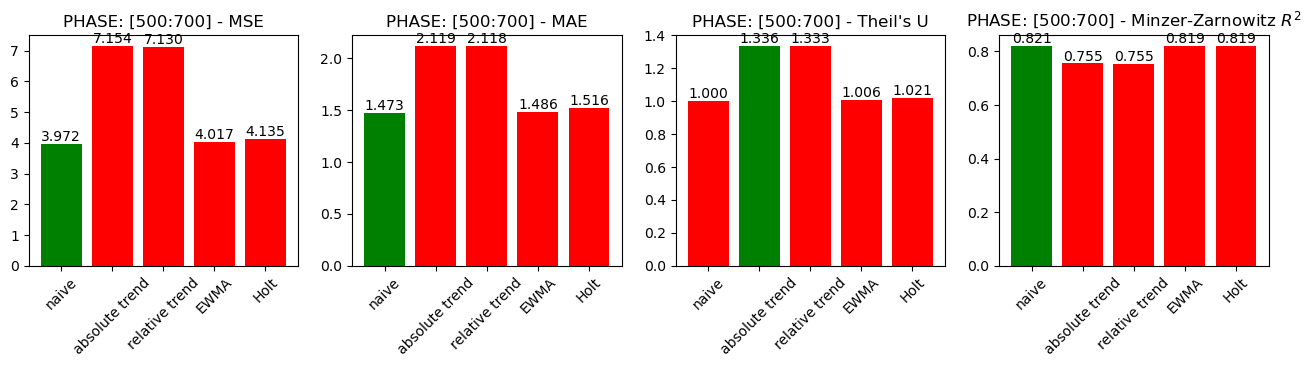

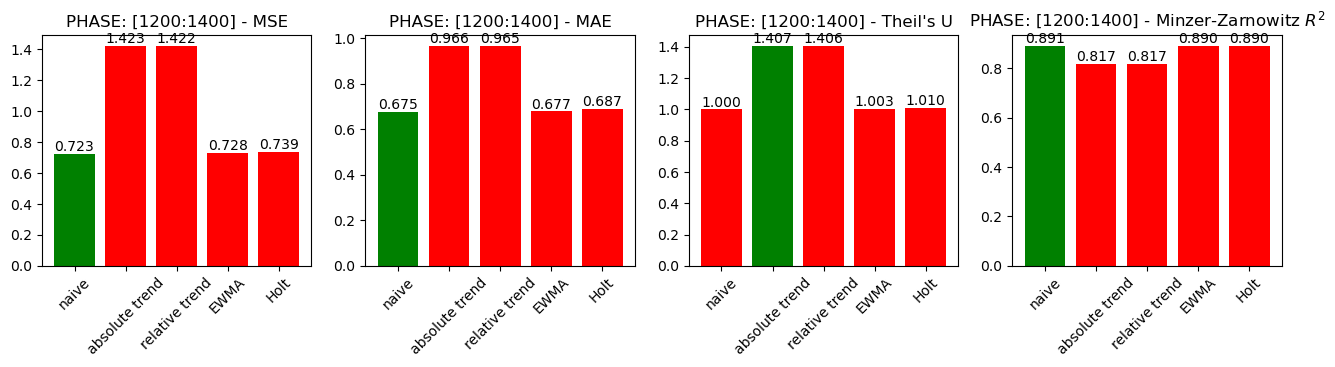

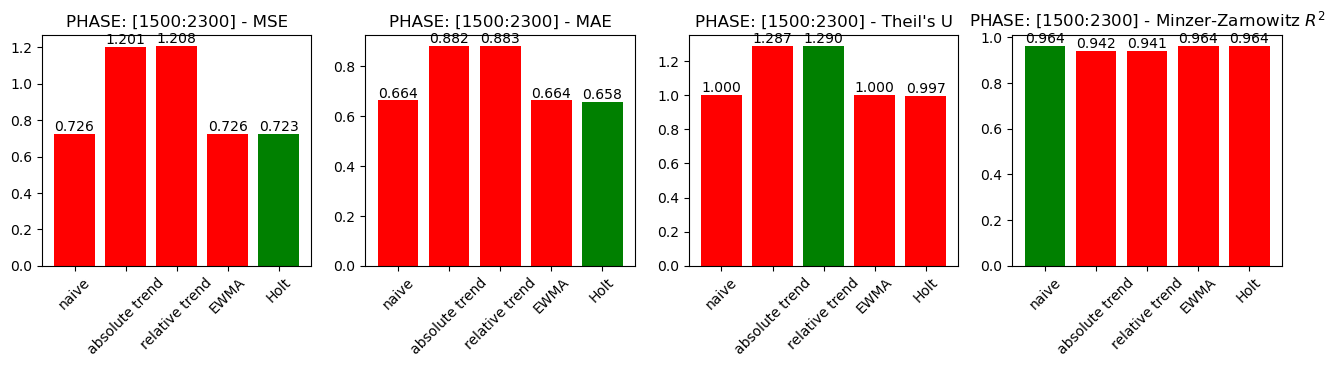

In [21]:
for start, end in phases:
    metrics = metrics_per_phase[f"{start}:{end}"]
    
    plt.figure(figsize=(16, 3))
    print()
    i = 1
    for metric, metrics_per_method in metrics.items():
        methods = metrics_per_method.keys()
        values = metrics_per_method.values()
        if metric in ['MSE', 'MAE']:
            highlight_index = list(values).index(min(values))
        else:
            highlight_index = list(values).index(max(values))
        colors = ['red'] * len(values)
        colors[highlight_index] = 'green'
        plt.subplot(1, len(metrics.items()), i)
        bars = plt.bar(methods, values, color=colors)
        plt.title(f'PHASE: [{start}:{end}] - {metric}')
        plt.xticks(rotation=45)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, '{:.3f}'.format(yval), ha='center', va='bottom')

        i +=1

From the results above, we can see that for the 1st (500, 700) and 2nd (1200, 1400) phases according to MSE, MAE and Minzer-Zarnowitz $R^2$ the best are naive forecasts, but according to Theil's U absolute trend forecast are quite better.

The 3rd phase (1500, 2300) has another results: according to MSE and MAE the best one is Holt forecast, Theil's U chooses relative trend forecast, and according to Minzer-Zarnowitz $R^2$ it's better to use naive forecast.

From the plots above and from the numerical results we can conclude that naive forecast is a good one for noisy ime series with obvious trend, the naive forecast works well. Absolute and relative trends are good for less nosy, but also with obvious trend time series. For time series with no trend and no seasonality EWMA approach is good enough as it takes into account the historical data while Holt method is good for time series with trend as it includes both global and local trends.

# Task #3
## Simple forecasting and forecasting with exponential smoothing with $BeerWineUS.csv$. Begin the forecasting starting with the observation $201$. Thus the out-of-sample performance of the below methods will be assessed using the forecasts for the periods $201$ to $311$.
### (a) Compute forecasts using simple EWMA, Holt and Holt-Winters forecasts with the smoothing parameters calibrated from the first $200$ observations.

Now let's explore another dataset, which contains seasonality, and try to do the forecasting by the same techniques (EWMA, Holt) and try a new one (Holt-Winter):
$$L_t = \alpha (Y_t-S_{t-s}) + (1 - \alpha)(L_{t-1} + T_{t-1}) \qquad \text{global trend}$$
$$T_t = \beta(L_t - L_{t-1}) + (1 - \beta)T_{t-1} \qquad \text{local trend}$$
$$S_t = \gamma(Y_t - L_t) + (1 - \gamma)S_{t-s} \qquad \text{seasonal component}$$
$$\hat{Y}_{t+h} = L_t + T_th + S_{t-s+h}$$

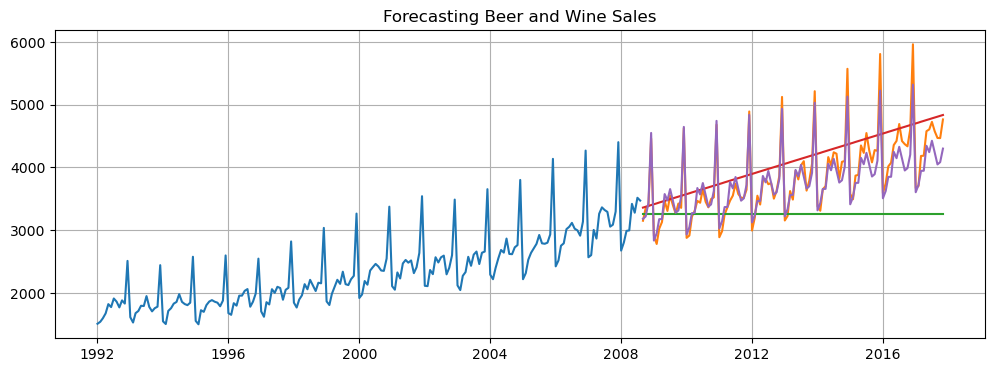

In [22]:
beer_wine_df = beer_wine_df.asfreq('MS')

train = beer_wine_df.iloc[:200]
test = beer_wine_df.iloc[200:311]

# EWMA Model
ewma_model = SimpleExpSmoothing(train, initialization_method='estimated').fit(optimized=True)
ewma_forecast = ewma_model.forecast(len(test))

# Holt's Linear Trend Model
holt_model = Holt(train).fit(optimized=True)
holt_forecast = holt_model.forecast(len(test))

# Holt-Winters Model
hw_model = ExponentialSmoothing(train, trend='additive', seasonal='add', seasonal_periods=12).fit(optimized=True)
hw_forecast = hw_model.forecast(len(test))

plt.figure(figsize=(12, 4))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(ewma_forecast, label='EWMA Forecast')
plt.plot(holt_forecast, label='Holt Forecast')
plt.plot(hw_forecast, label='Holt-Winters Forecast')
plt.title('Forecasting Beer and Wine Sales')
plt.grid()
plt.show()

So, from these plots we can recognize the main assumptions of the methods:

* EWMA assumes that there is no trend and no seasonality

* Holt assumes that there is a trend

* Holt-Winter assumes that there is both trend and seasonality

So, the worse method for this time series forecasting is EWMA and the best one is Holt-Winter.

### (b) Compute the corresponding MSE losses. Check the ACF of the forecast errors.

Now, let's evaluate these methods by calculating MSE losses and check the ACF of residuals.

EWMA MSE: 744658.3938717295
Holt MSE: 284629.27929006616
Holt-Winters MSE: 39294.71738220363


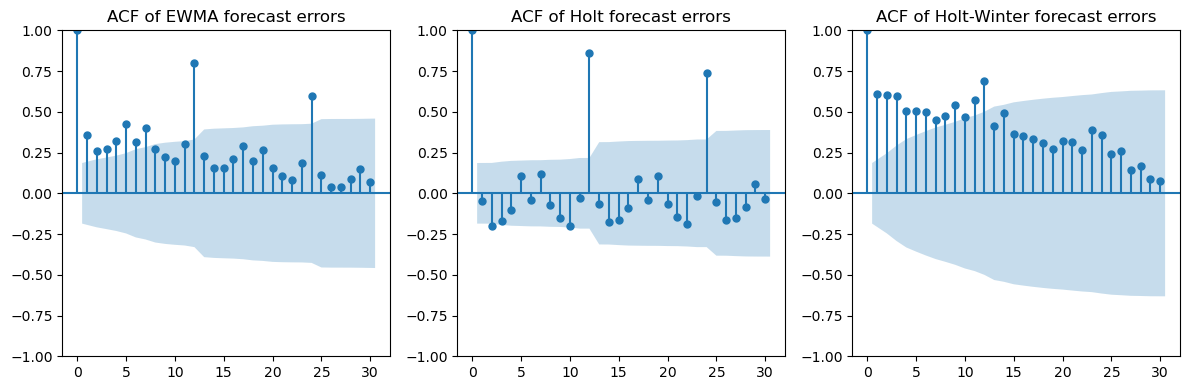

In [23]:
ses_mse = mean_squared_error(test, ewma_forecast)
holt_mse = mean_squared_error(test, holt_forecast)
hw_mse = mean_squared_error(test, hw_forecast)

print(f'EWMA MSE: {ses_mse}')
print(f'Holt MSE: {holt_mse}')
print(f'Holt-Winters MSE: {hw_mse}')

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_acf(test.squeeze() - ewma_forecast, lags=30, ax=axes[0], title='ACF of EWMA forecast errors')
plot_acf(test.squeeze() - holt_forecast, lags=30, ax=axes[1], title='ACF of Holt forecast errors')
plot_acf(test.squeeze() - hw_forecast, lags=30, ax=axes[2], title='ACF of Holt-Winter forecast errors')
plt.tight_layout()
plt.show()

From the MSE scores we can see that Holt-Winter approach is quite better than the rest.

The ACF of EWMA and Holt residuals identifies the clear seasonality in the errors. For ACF we don't see such property.

### (c) Compare the performance of the models using one of the three tests discussed in the lectures.

For statistical comparing of models performance I will use Wilcoxon test.

Let's define teh hypothesis:

$H_0$ - both models are equivalent
$H_1$ - one model is better

The test statistics is:
$$d_t = (Y_t - \hat{Y}_t^{'})^2 + (Y_t - \hat{Y}_t^{''})^2$$

In [24]:
_, p_value_ewma_holt = wilcoxon((test.squeeze() - ewma_forecast)**2, (test.squeeze() - holt_forecast)**2)
_, p_value_ewma_hw = wilcoxon((test.squeeze() - ewma_forecast)**2, (test.squeeze() - hw_forecast)**2)
_, p_value_holt_hw = wilcoxon((test.squeeze() - holt_forecast)**2, (test.squeeze() - hw_forecast)**2)

print(f'Wilcoxon test p-value (EWMA vs Holt): {p_value_ewma_holt}')
print(f'Wilcoxon test p-value (EWMA vs Holt-Winters): {p_value_ewma_hw}')
print(f'Wilcoxon test p-value (Holt vs Holt-Winters): {p_value_holt_hw}')

Wilcoxon test p-value (EWMA vs Holt): 0.00016194972709091945
Wilcoxon test p-value (EWMA vs Holt-Winters): 1.400341585936968e-18
Wilcoxon test p-value (Holt vs Holt-Winters): 1.9639664117084866e-10


So, from the results above, as each $p$-value is significant small, we conclude that no pair of models provide the same performance.

As we concluded from the plots that the best forecasting method for our dataset is Holt-Winter and the worst - EWMA, our test results prove these conclusions: the $p$-value of the test "EWMA vs Holt-Winters" is the lowest, so it means the there is the biggest difference in the performance.

# Task #4
## ARMA modelling with interestrate.csv. Keep the last year for forecasting.
### (a) Check the ACF and decide about the strength of the memory in the time series using Box-Ljung/Pierce tests.

Now, let's look at interest rate dataset.

First of all, let's analyse the strength of the memory by looking at ACF.

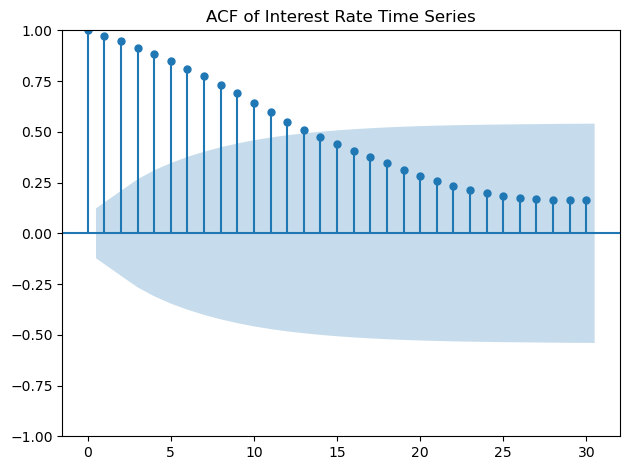

In [25]:
interest_rates_df = interest_rates_df.asfreq('MS')

plot_acf(interest_rates_df, lags=30, title='ACF of Interest Rate Time Series')
plt.tight_layout()
plt.show()

From the ACF plot we can see that it has a quite good memory, which indicates stationarity. 

Let's prove it statistically using Box/Ljung test.

$H_0$: the process is not autocorrelated.

$H_1$: the process is autocorrelated.

The test statistics is:
$$Q^* = \tau(\tau + 2) \sum\limits_{h=1}^{m}\frac{\hat{\rho}_h^2}{\tau - h}$$

In [26]:
result = acorr_ljungbox(interest_rates_df, lags=[30], return_df=True)
result['lb_pvalue'].values[0]

0.0

In this case, the $p$-value is very small (0.0) that indicates there is significant autocorrelation in the interest rate time series. This suggests a strong memory effect in the time series.

### (b) Try MA(1), AR(1) and ARMA(1,1) processes and check the fit (ACF of residuals, AIC, etc.)

Now let's start modelling time series with simple models:

* moving average process of order 1 MA(1):
$$Y_t = u_t + \beta_1u_{t-1} + \dots + \beta_qu_{t-q} \qquad \text{with} \qquad \{u_t\}\sim WN$$

* autoregressive process of order 1 AR(1):
$$Y_t = \sum\limits_{v=1}^p \alpha_v Y_{t-v} + u_t \qquad with \qquad \{u_t\} \sim WN$$

* autoregressive moving average process of order (1, 1) ARMA(1,1):
$$Y_t = \mu + \sum\limits_{v=1}^p \alpha_v(Y_{t-v} - \mu) + u_t + \sum\limits_{j=1}^q \beta_j u_{t-j} \qquad \text{with} \qquad \{u_t\} \sim WN$$

In [27]:
# Fit MA(1) model
ma1_model = ARIMA(interest_rates_df, order=(0, 0, 1)).fit()
ma1_resid = ma1_model.resid
ma1_aic = ma1_model.aic

# Fit AR(1) model
ar1_model = ARIMA(interest_rates_df, order=(1, 0, 0)).fit()
ar1_resid = ar1_model.resid
ar1_aic = ar1_model.aic

# Fit ARMA(1,1) model
arma11_model = ARIMA(interest_rates_df, order=(1, 0, 1)).fit()
arma11_resid = arma11_model.resid
arma11_aic = arma11_model.aic

Let's look at ACF of residuals:

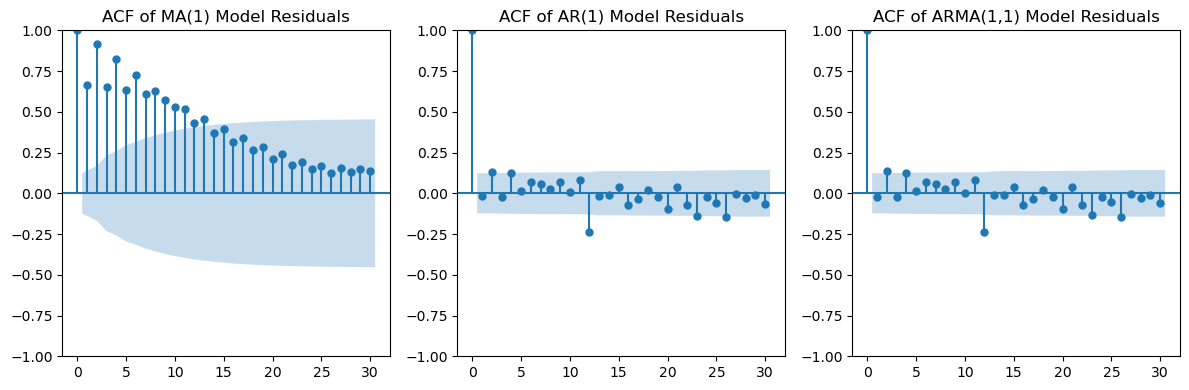

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_acf(ma1_resid, lags=30, ax=axs[0], title='ACF of MA(1) Model Residuals')
plot_acf(ar1_resid, lags=30, ax=axs[1], title='ACF of AR(1) Model Residuals')
plot_acf(arma11_resid, lags=30, ax=axs[2], title='ACF of ARMA(1,1) Model Residuals')
plt.tight_layout()
plt.show()

So, here we can see that MA(1) residuals has a strong memory, while AR(1) and ARMA(1, 1) hasn't. It can identify that AR(1) and ARMA(1, 1) models are quite better.

Let's look at AIC scores to prove it:

In [29]:
print(f"MA(1) AIC: {ma1_aic}")
print(f"AR(1) AIC: {ar1_aic}")
print(f"ARMA(1,1) AIC: {arma11_aic}")

MA(1) AIC: 788.5238658972628
AR(1) AIC: 287.5805453487448
ARMA(1,1) AIC: 289.5631125812954


From these results, we can prove that MA(1) model has significantly worse performance. AR(1) and ARMA(1) provide almost the same performance.

Let's prove it also by the statistical significance test (Ljung-Box):

$H_0$: the residuals are not autocorrelated.

$H_1$: the residuals are autocorrelated.

The test statistics is:
$$Q^* = \tau(\tau + 2) \sum\limits_{h=1}^{m}\frac{\hat{\rho}_h^2}{\tau - h}$$

In [30]:
ljung_box_ma1 = acorr_ljungbox(ma1_resid, lags=[30])
ljung_box_ar1 = acorr_ljungbox(ar1_resid, lags=[30])
ljung_box_arma11 = acorr_ljungbox(arma11_resid, lags=[30])

print(f"Ljung-Box Test for MA(1) Model Residuals: {ljung_box_ma1['lb_pvalue'].values[0]:.5f}")
print(f"Ljung-Box Test for AR(1) Model Residuals: {ljung_box_ar1['lb_pvalue'].values[0]:.5f}")
print(f"Ljung-Box Test for ARMA(1,1) Model Residuals: {ljung_box_arma11['lb_pvalue'].values[0]:.5f}")

Ljung-Box Test for MA(1) Model Residuals: 0.00000
Ljung-Box Test for AR(1) Model Residuals: 0.01318
Ljung-Box Test for ARMA(1,1) Model Residuals: 0.01335


So, given these results we can conclude that all the models have autocorrelation in the residuals. It indicates that even if AR(1) and ARMA(1, 1) provide significantly better AIC score, but they are still not good enough.

### (c) Try differencing and subsequent application of MA(1), AR(1) and ARMA(1,1). Check again the processes and check the fit (significance, ACF, AIC, etc.) Decide which model is the best one.

One of the approaches to attain stationarity is to difference the data.
$$\Delta Y_t = Y_t - Y_{t-1}$$

Let's try it and analyse the results:

In [31]:
differenced_data = np.diff(interest_rates_df['INTEREST_RATE'])

# Fit MA(1) model
ma1_model_diff = ARIMA(differenced_data, order=(0, 0, 1)).fit()
ma1_resid_diff = ma1_model_diff.resid
ma1_aic_diff = ma1_model_diff.aic

# Fit AR(1) model
ar1_model_diff = ARIMA(differenced_data, order=(1, 0, 0)).fit()
ar1_resid_diff = ar1_model_diff.resid
ar1_aic_diff = ar1_model_diff.aic

# Fit ARMA(1,1) model
arma11_model_diff = ARIMA(differenced_data, order=(1, 0, 1)).fit()
arma11_resid_diff = arma11_model_diff.resid
arma11_aic_diff = arma11_model_diff.aic

So, look at ACF of the models' residuals:

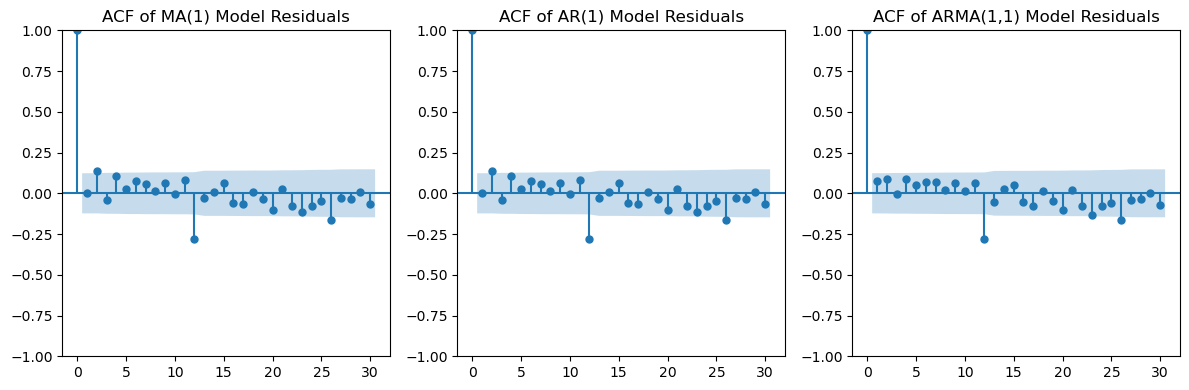

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_acf(ma1_resid_diff, lags=30, ax=axs[0], title='ACF of MA(1) Model Residuals')
plot_acf(ar1_resid_diff, lags=30, ax=axs[1], title='ACF of AR(1) Model Residuals')
plot_acf(arma11_resid_diff, lags=30, ax=axs[2], title='ACF of ARMA(1,1) Model Residuals')
plt.tight_layout()
plt.show()

So, we can see that MA(1) looks quite better, while AR(1) and ARMA(1, 1) look almost the same.

So, now all the models look quite similar, let's check it by AIC scores:

In [33]:
print(f"MA(1) AIC: {ma1_aic_diff}")
print(f"AR(1) AIC: {ar1_aic_diff}")
print(f"ARMA(1,1) AIC: {arma11_aic_diff}")

MA(1) AIC: 286.6715630934975
AR(1) AIC: 286.6713288745928
ARMA(1,1) AIC: 286.4084430803882


As expected all the AIC scores are almost equal, but ARMA (1, 1) is a little bit better.

Let's check the significance of residuals' memory by the same test as previously.

In [34]:
ljung_box_ma1 = acorr_ljungbox(ma1_resid_diff, lags=[30], return_df=True)
ljung_box_ar1 = acorr_ljungbox(ar1_resid_diff, lags=[30], return_df=True)
ljung_box_arma11 = acorr_ljungbox(arma11_resid_diff, lags=[30], return_df=True)

print(f"Ljung-Box Test for MA(1) Model Residuals: {ljung_box_ma1['lb_pvalue'].values[0]:.5f}")
print(f"Ljung-Box Test for AR(1) Model Residuals: {ljung_box_ar1['lb_pvalue'].values[0]:.5f}")
print(f"Ljung-Box Test for ARMA(1,1) Model Residuals: {ljung_box_arma11['lb_pvalue'].values[0]:.5f}")

Ljung-Box Test for MA(1) Model Residuals: 0.00107
Ljung-Box Test for AR(1) Model Residuals: 0.00107
Ljung-Box Test for ARMA(1,1) Model Residuals: 0.00119


So, results are the same, we can conclude that all the models have autocorrelation in residuals, so they are not good enough to model the process.

### (d) Try autoarima (in R) and compare the final model with the one you found in the previous step.

Let's try to find the best orders for modelling our process using autoarima staff.

First find autoarima of time series itself:

Order of the ARIMA model: (0, 1, 0)
Ljung-Box Test for Auto ARIMA Model Residuals: 0.01823
Auto ARIMA Model AIC: 282.7850975560068


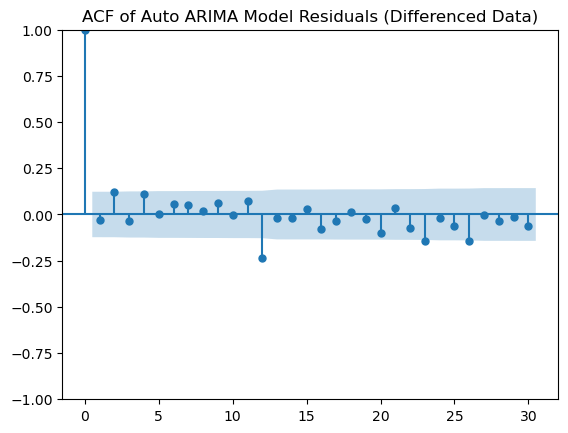

In [35]:
auto_model = auto_arima(interest_rates_df, seasonal=False, trace=False, stepwise=True)

model_order = auto_model.order
print("Order of the ARIMA model:", model_order)

auto_resid = auto_model.resid()

ljung_box_auto = acorr_ljungbox(auto_resid, lags=[30], return_df=True)
print(f"Ljung-Box Test for Auto ARIMA Model Residuals: {ljung_box_auto.iloc[0]['lb_pvalue']:.5f}")

auto_aic = auto_model.aic()
print(f"Auto ARIMA Model AIC: {auto_aic}")

plot_acf(auto_resid, lags=30)
plt.title('ACF of Auto ARIMA Model Residuals (Differenced Data)')
plt.show()

Given the results we can see that ARIMA (0, 1, 0) is selected as the best model. It has a little bit better AIC score than previous models, but it still has autocorrelation is residuals.

The (0,1,0) model is essentially a simple random walk with drift, implying that the best model for our original series is just differencing it once to achieve stationarity, without further AR or MA components.

So, let's find autoarima of differenced time series:

Order of the ARIMA model: (0, 0, 0)
Ljung-Box Test for Auto ARIMA Model Residuals: 0.00108
Auto ARIMA Model AIC: 282.7850975559899


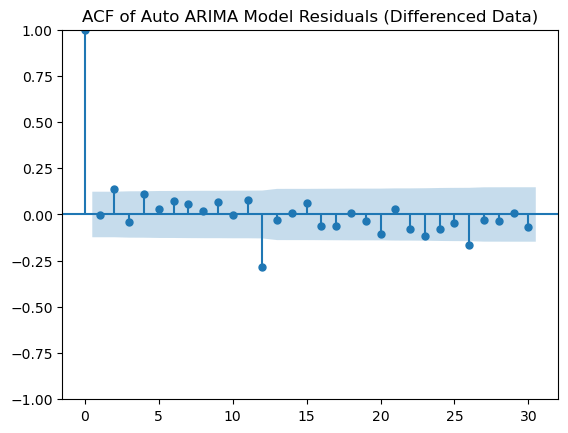

In [36]:
auto_model = auto_arima(differenced_data, seasonal=False, trace=False, stepwise=True)

model_order = auto_model.order
print("Order of the ARIMA model:", model_order)

auto_resid = auto_model.resid()

ljung_box_auto = acorr_ljungbox(auto_resid, lags=[30], return_df=True)
print(f"Ljung-Box Test for Auto ARIMA Model Residuals: {ljung_box_auto.iloc[0]['lb_pvalue']:.5f}")

auto_aic = auto_model.aic()
print(f"Auto ARIMA Model AIC: {auto_aic}")

plot_acf(auto_resid, lags=30)
plt.title('ACF of Auto ARIMA Model Residuals (Differenced Data)')
plt.show()

So, having (0,0,0) model on the differenced series indicates that the differenced series is already white noise, and thus no further AR or MA terms are necessary.

This analysis suggests that the original time series is best modeled as a random walk, meaning it follows a path where future values are simply the previous value plus some random noise.

### (e) Compute the forecasts and forecast intervals using the final model.

Having the best possible model let's try to compute the forecasts and forecast intervals.

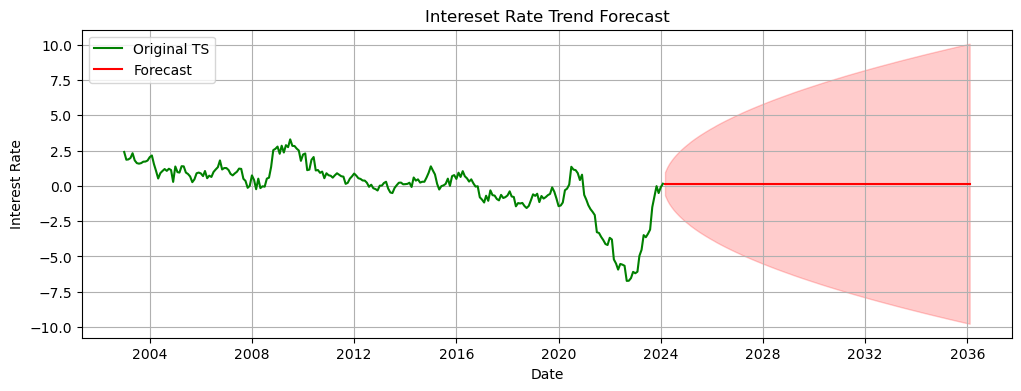

In [37]:
auto_model = auto_arima(interest_rates_df, seasonal=False, trace=False, stepwise=True)
forecast, conf_int = auto_model.predict(n_periods=144, return_conf_int=True)
last_date = interest_rates_df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=144, freq='MS')

plt.figure(figsize=(12,4))
plt.plot(interest_rates_df.index, interest_rates_df['INTEREST_RATE'], color='green', label='Original TS')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Intereset Rate Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.grid()
plt.show()

As I assumed as the model is a random walk, then the best prediction is the mean value.

### (f) Explain why multi-step-ahead forecasts have wider forecast intervals than one-step-ahead-forecasts.

The explaining is quite logical, multi-step-ahead forecasts have wider forecast intervals, because of the accumulation of uncertainty over time. We are not able to build an excellent model, which will always cover our time series. Then having some error on one step, each further forecast step introduces additional error, which accumulates over time, leading to a broader range of possible future values.

### (g) Imagine an ACF with only the first two correlations being significant. Which process is suitable to model this and why?

Having only first two correlations being significant, we can conclude that there is autocorrelation at lags 1 and 2 and no significant correlation at further lags. It identifies that the process depends on the current and the past 2 white noise terms, which matches the expected behavior of MA(2) process by its structure:
$$\hat{Y}_{t+1} = \frac{1}{k}\sum\limits_{j=t-k+1}^t Y_j$$
So, for forecasting $t+1$ element we take into account $t$ and $t - 1$ elements.

### (h) Imagine an ACF which consists only of positive values and quickly decays towards zero. Which process is suitable to model this and why?

Only positive and quickly decay towards zero ACF values identifies an exponential decay, which characterizes autoregressive process AR(p). The quick decay in the ACF indicates that the influence of past values diminishes rapidly, a behavior consistent with lower-order AR processes, particularly AR(1) or AR(2).
$$Y_t = \sum\limits_{v=1}^p \alpha_v Y_{t-v} + u_t$$

# Task #5
## GARCH modelling of the crude oil prices. Compute the log-returns of the oil prices, i.e. $r_t = \log(\frac{Y_t}{Y_{t−1}})$ and work with this time series.
### (a) Check the ACF of the returns and squared returns. Which specific features do the ACFs have?

As previously we didn't manage to find a good enough model, let's try some non-linear models. 

Now, I'm going to try GARCH modelling approach on the crude oil prices dataset.

First let's build log-returns:

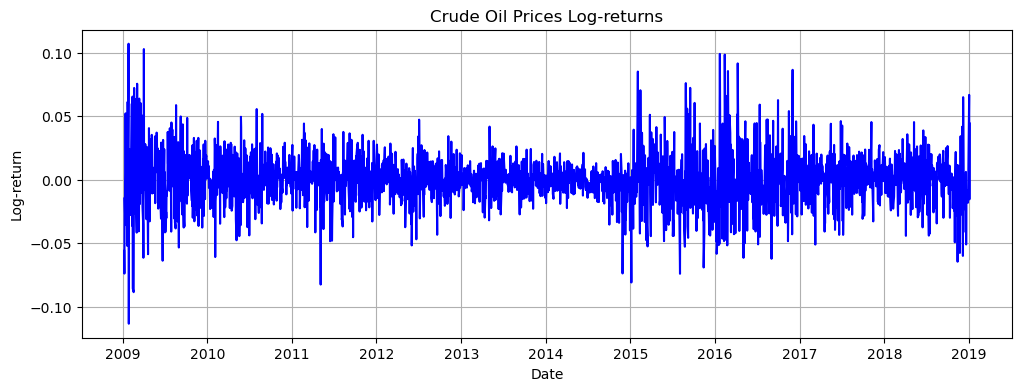

In [38]:
crude_oil_step_ahead = np.array(crude_oil_df['DCOILBRENTEU'])[1:]
crude_oil_step_back = np.array(crude_oil_df['DCOILBRENTEU'])[:-1]
crude_oil_log = np.log(crude_oil_step_ahead / crude_oil_step_back)

plt.figure(figsize=(12,4))
plt.plot(np.array(crude_oil_df.index)[1:], crude_oil_log, color='blue')
plt.title('Crude Oil Prices Log-returns')
plt.xlabel('Date')
plt.ylabel('Log-return')
plt.grid()
plt.show()

We can see that such transformed time series has conditional heteroskedasticity (phases of high volatility alternate with phases of low volatility).

Now let's analyse ACF of log-returns and squared-returns:

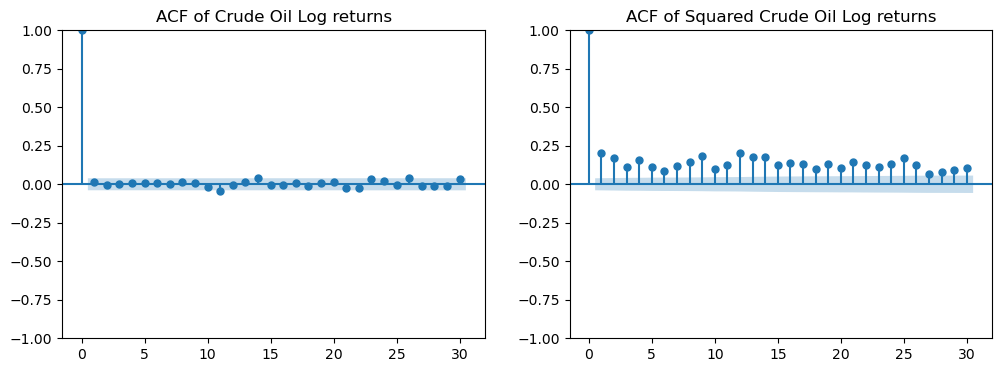

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(crude_oil_log, lags=30, ax=axes[0], title='ACF of Crude Oil Log returns')
plot_acf(crude_oil_log**2, lags=30, ax=axes[1], title='ACF of Squared Crude Oil Log returns')
plt.show()

So, we can see that log-returns has no significant memory, while squared log-returns has significant for every lag.

### (b) Fit ARCH(1) and GARCH(1,1) processes to the data. Extract the conditional volatilities and plot them.

Now let's try to use ARCH(1) and GARCH(1, 1) models for extraction volatilities.

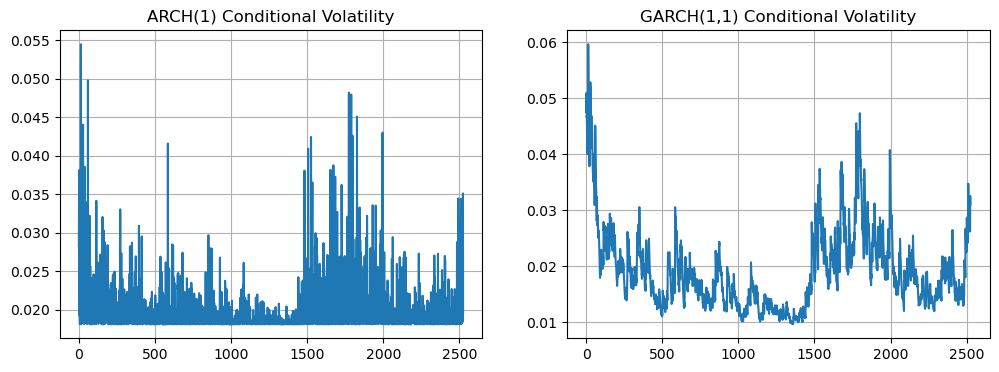

In [40]:
arch_model_1 = arch_model(crude_oil_log, vol='ARCH', p=1, rescale=False)
arch_fit = arch_model_1.fit(disp='off')
arch_volatility = arch_fit.conditional_volatility

garch_model_1_1 = arch_model(crude_oil_log, vol='Garch', p=1, q=1, rescale=False)
garch_fit = garch_model_1_1.fit(disp='off')
garch_volatility = garch_fit.conditional_volatility

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(arch_volatility)
plt.title('ARCH(1) Conditional Volatility')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(garch_volatility)
plt.title('GARCH(1,1) Conditional Volatility')
plt.grid()
plt.show()

### (c) Check the properties of the residuals and choose the optimal model relying on BIC.

Let's try to find the best possible model from the ARCH and GARCH families with orders from 1 to 4.

In [41]:
optimal_model = None
optimal_bic = None

# ARCH models
for p in range(1, 4):
    model = arch_model(crude_oil_log, vol='ARCH', p=p, rescale=False)
    fit = model.fit(disp='off')
    if not(optimal_model) or optimal_bic > fit.bic:
        optimal_model = fit
        optimal_bic = fit.bic

# GARCH models
for p in range(1, 4):
    for q in range(1, 4):
        model = arch_model(crude_oil_log, vol='Garch', p=p, q=q, rescale=False)
        fit = model.fit(disp='off')
        if optimal_bic > fit.bic:
            optimal_model = fit
            optimal_bic = fit.bic

print(f"The optimal model based on BIC is: {optimal_model.model.volatility} with BIC {optimal_bic:.2f}")

The optimal model based on BIC is: GARCH(p: 2, q: 2) with BIC -13080.87


So, the best model is GARCH(2, 2), which provieds BIC score of -13080.87.

Let's analyse its residuals ploting its histogram and ACF.

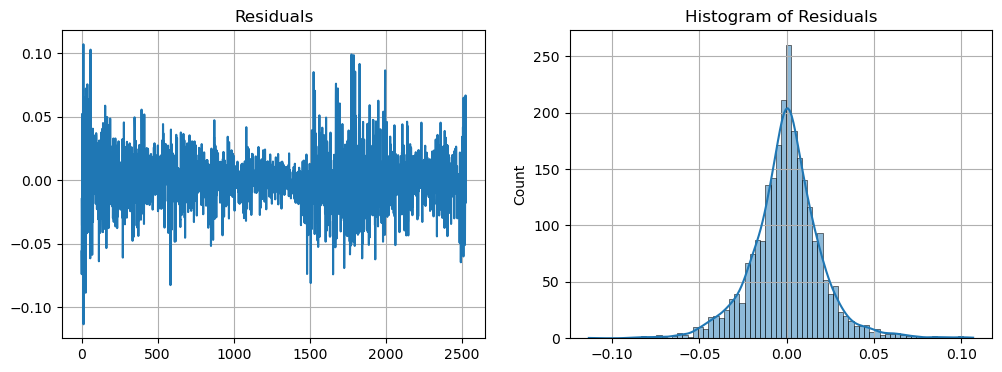

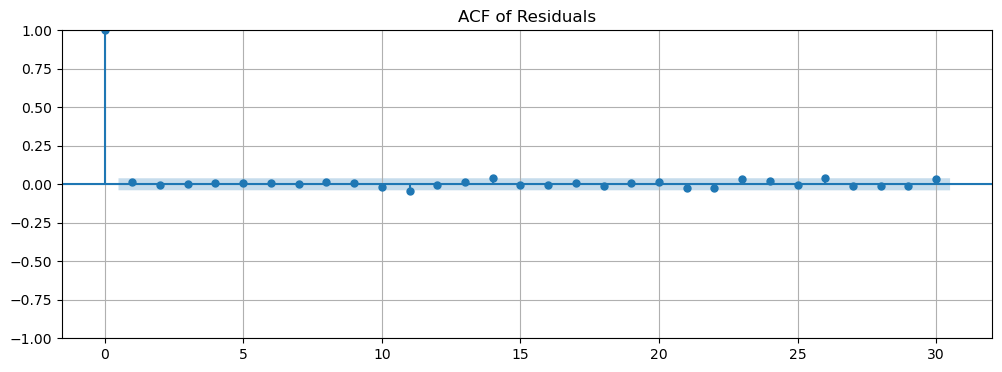

In [42]:
residuals = optimal_model.resid

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals')
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plot_acf(residuals, ax=plt.gca(), lags=30)
plt.title('ACF of Residuals')
plt.grid()
plt.show()

From the histogram we can notice the residuals of the selected model are normally distributed. From the ACF and test results we can conclude that they have no significant autocorrelation. Thus, these residuals are white noise.

Therefore, the selected model is a good fit for the data.

Let's prove it statistically by the Box/Ljung test:

In [43]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"Ljung-Box test p-value: {lb_test['lb_pvalue'].values}")

Ljung-Box test p-value: [0.98726369]


So, as expected $p$-value is quite big, so we can reject the null hypothesis and conclude that there is no significant autocorrelation in residuals.

### (d) Explain in your own words the difference between conditional and unconditional volatility.

Conditional volatility refers to the variability of a variable that depends on specific conditions or information available at a given time. To predict the future volatility we need to consider past data.

Unconditional one represents the overall average level of volatility of a variable, without considering any information related to specific time. It provides a general sense of how much the variable tends to fluctuate over time.

In conclusion, conditional volatility is dynamic and depends on recent information related to specific time, while unconditional volatility is a static measure that characterize the overall historical variability of a variable.

### (e) Explain in your own words idea behind the news impact curve.

The news impact curve is a measure that describes how new data affects the volatility in the next period. It helps to understand how time series will behavior in a future that provides some expectations about the possible future. GARCH model incorporate this idea to better predict future volatility by considering how past data has affected the further behavior.

# Task #6
## Structural breaks with the crude oil price.
### (a) The objective is to determine the intervals where the time series shows homogenous behaviour. Apply either breakspoints or a regression-tree type approach to find the intervals where
#### i. the time is series is well approximated by constants;

In [44]:
crude_oil_df = pd.read_csv('CrudeOil.csv')
crude_oil_df['DATE'] = pd.to_datetime(crude_oil_df['DATE'])
reference_date = crude_oil_df['DATE'].min()
crude_oil_df['DATE_INT'] = (crude_oil_df['DATE'] - reference_date).dt.days
crude_oil_df = crude_oil_df.dropna()

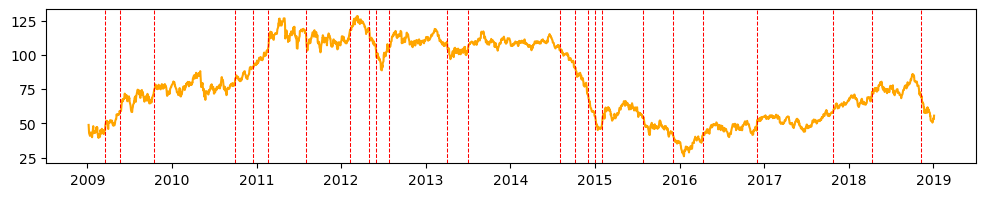

In [45]:
model = "l2"
algo = rpt.Pelt(model=model).fit(crude_oil_df['DCOILBRENTEU'].values)
result_const = algo.predict(pen=1000)

plt.figure(figsize=(12, 2))
plt.plot(crude_oil_df['DATE'].values, crude_oil_df['DCOILBRENTEU'].values, label='intercept', color='orange')
for cp in result_const[:-1]:
    plt.axvline(x=crude_oil_df['DATE'].values[cp], color='r', linestyle='--', linewidth=0.75)

#### ii. the time is series is well approximated by linear trends;

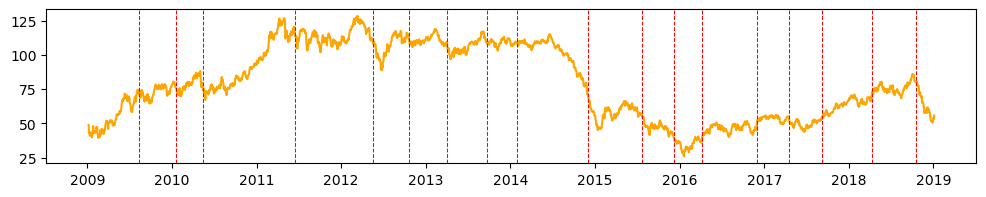

In [46]:
model = "linear"
date_price_list = crude_oil_df[['DATE_INT', 'DCOILBRENTEU']].values.tolist()
algo = rpt.Window(model=model).fit(np.array(date_price_list))
result_const = algo.predict(pen=1000)

plt.figure(figsize=(12, 2))
plt.plot(crude_oil_df['DATE'].values, crude_oil_df['DCOILBRENTEU'].values, label='intercept', color='orange')
for cp in result_const[:-1]:
    plt.axvline(x=crude_oil_df['DATE'].values[cp], color='r', linestyle='--', linewidth=0.75)

### (b) Compute moving window estimates for OLS parameters (use $100$ observations) of the oil price on a simple time variable. Plot the results and decide about the breaks.

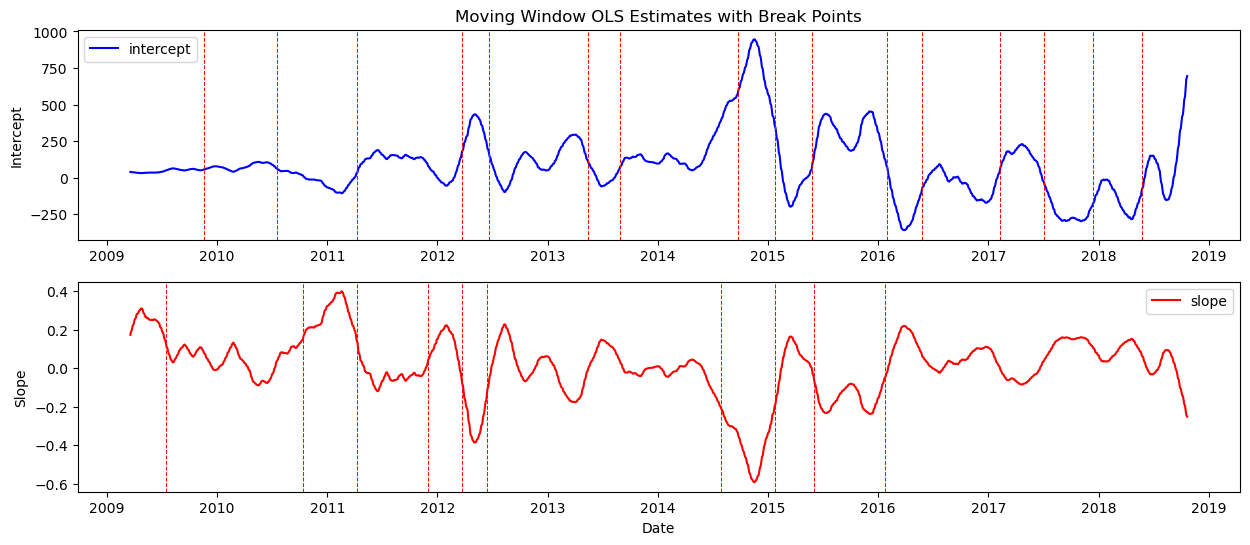

In [47]:
crude_oil_df['TIME'] = np.arange(len(crude_oil_df))
window_size = 100

betas = []
intercepts = []
window_midpoints = []

for start in range(len(crude_oil_df) - window_size + 1):
    end = start + window_size
    window_data = crude_oil_df[start:end]
    
    X = add_constant(window_data['TIME'])
    y = window_data['DCOILBRENTEU']
    
    model = OLS(y, X).fit()
    intercepts.append(model.params[0])
    betas.append(model.params[1])
    window_midpoints.append(window_data['DATE'].iloc[window_size // 2])

intercepts = np.array(intercepts)
betas = np.array(betas)

model = "l2"

algo_intercepts = rpt.Window(model=model).fit(intercepts)
change_points_intercepts = algo_intercepts.predict(pen=1)

algo_betas = rpt.Pelt(model=model).fit(betas)
change_points_betas = algo_betas.predict(pen=1)

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(window_midpoints, intercepts, label='intercept', color='blue')
for cp in change_points_intercepts[:-1]:
    plt.axvline(x=window_midpoints[cp], color='r', linestyle='--', linewidth=0.75)
plt.title('Moving Window OLS Estimates with Break Points')
plt.ylabel('Intercept')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(window_midpoints, betas, label='slope', color='red')
for cp in change_points_betas[:-1]:
    plt.axvline(x=window_midpoints[cp], color='r', linestyle='--', linewidth=0.75)
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

### (c) Explain the consequences of breaks in time series for modelling. You can pick up a particular model to motivate your ideas.

A break in a time series occurs when there is a sudden change in the underlying process generating the data. Breaks can manifest as changes in the mean, variance, or autocorrelation structure of the series. Mostly it has a crucial impact on modelling.

First of all, breaks can lead to significant errors in forecasts. If the model is trained on the data before the break, it might fail to capture the new pattern after break, which leads to poor forecast accuracy.

ARIMA models, for example, rely on stable relationships between past values and future values. A break can lead to instability in the estimated parameters, making the model less reliable. For example, the coefficients estimated for an ARIMA model before a break may no longer be valid after the break.

Additionally, most of scors, like AIC, BIC, as well as statistical tests and confidence intervals could provide misleading results.

### (d) Explain the consequences of breaks in time series for forecasting. Think about the forecasting method, time point of the break, etc.

Moreover, if we talk about forecasting, the breaks can significantly affect the performance of forecasting methods.

Different forecasting methods have varying degrees of sensitivity to breaks in time series data, but most of them rely on the historical data, thus breaks can lead to parameter instability. A break causes sudden changes that these models cannot adapt quickly. For example, ARIMA methods assume that the relationships between past and future values are stable over time, exponential smoothing techniques also assume the stability in trend and seasonality. Even neural networks, which handle non-linearities better, still rely on the historical data patterns, so training data are also affective for them.

The time of break could have different impact on the forecasting. For example, if a break occurs just before the start of the forecast period, the model may not have enough data after break to capture the new pattern. When a break occurs in the middle of historical data, it can cause parameter instability and reduce the reliability of the entire model. The break impact may be minimized if it happened long time ago, then the model can adjust to the new pattern over time.